In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Calibration

**Author:** Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2021

**Recommended datasample(s):** any simtel file

**Data level(s):** simtel (raw data)

**Description:**

This notebook provides calibration benchmarks for any version of the *protopipe* pipeline.

**Requirements and steps to reproduce:**

It can be used with any camera and any image extractor from any simtel file of any production supported by *ctapipe*.

To get a filled notebook and reproduce these results,

- get the necessary input files using ``ctapipe-process`` with the proper configuration

    - create 1st pass data,

``ctapipe-process --config protopipe_CTAMARS_1stPass_DL1a.json``
<br>
``--input XXX.simtel.gz``

    - create 2nd pass data (if needed by the selected image extractor),

``ctapipe-process --config protopipe_CTAMARS_2ndPass_DL1a.json``
<br>
``--input XXX.simtel.gz``

- execute the notebook,

``papermill benchmarks_DL1a_calibration.ipynb results_benchmarks_DL1a_calibration.ipynb``

specifying each required parameter as ``-p name value``.

To obtain the list of all available parameters add ``--help-notebook``.

You can pretty-print it in HTML format with,

``jupyter nbconvert results_benchmarks_DL1a_calibration.ipynb``
<br>
``--to html --TagRemovePreprocessor.remove_cell_tags \"remove_input\" --no-input``

**Comparison between *protopipe* and *CTAMARS***:

- the simtel reference file is ``gamma_20deg_180deg_run100__cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz``
- ``calibscale`` should be set to 0.92, but we need to take 2.5% off (under investigation)
- the configuration files are provided with this notebook.

## Table of contents

- [Correlation between reconstructed and true number of photoelectrons](#Correlation-between-reconstructed-and-true-number-of-photoelectrons)
- [Charge resolution](#Charge-resolution)
- [Average residual bias](#Average-residual-bias)
- [Charge resolution corrected for the average residual bias](#Charge-resolution-corrected-for-the-average-residual-bias)
- [RMS of charge resolution around 1](#RMS-of-charge-resolution-around-1)
- [Performance of 2nd pass](#Performance-of-2nd-pass)
    - [Corrected charge resolution and average residual bias](#Corrected-charge-resolution-and-average-residual-bias)
    - [RMS around 1 comparison between passes](#RMS-around-1-comparison-between-passes)
    - [Comparison of charge resolution y-profiles between passes](#Comparison-of-charge-resolution-y-profiles-between-passes)
- [Single-pixels spectra and optimized cleaning thresholds](#Single-pixels-spectra-and-optimized-cleaning-thresholds)
    - [Comparison between 1st or single passes](#Comparison-between-1st-or-single-passes)
    - [Comparison between 2nd passes](#Comparison-between-2nd-passes)
    - [Comparison between true and reconstructed spectra](#Comparison-between-true-and-reconstructed-spectra)
- [Charge resolution and bias for true signal pixels](#Charge-resolution-and-bias-for-true-signal-pixels)
- [Noise distribution](#Noise-distribution)

## Imports
[back to top](#Table-of-contents)

In [2]:
from pathlib import Path
import json
import yaml

import warnings
warnings.filterwarnings(action='ignore', message="invalid value encountered in true_divide")

import uproot
import numpy as np
from scipy.stats import binned_statistic
import astropy.units as u
from astropy.table import Column, vstack, join
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
sns.set_context("talk")

single_plot_height = 6
single_plot_width = 8

double_plot_height = 8
double_plot_width = 16

import ctapipe
from ctapipe.instrument import SubarrayDescription
try:
    from ctapipe.io import read_table
except ImportError:
    from ctapipe.io.astropy_helpers import h5_table_to_astropy as read_table

## Functions
[back to top](#Table-of-contents)

In [3]:
def compute_weight_BTEL1010(true_energy):
    """Compute the weight from requirement B-TEL-1010-Intensity-Resolution."""
    target_slope = -2.62 # this is the spectral slope as required by the B-TEL-1010 "Intensity Resolution" doc
    spec_slope = -2.0 # this is the spectral slope in the simtel files
    # each pixel of the same image (row of data table) needs the same weight
    weight = np.power(true_energy/200., target_slope - spec_slope)
    return weight

In [4]:
def calc_bias(x_bin_edges, y_bin_edges, hist):
    """Calculate the average bias of charge resolution from 50 to 500 true photoeletrons.
    These limits are chosen in order to be safely away from saturation and from NSB noise.
    
    Parameters
    ----------
    x_bin_edges : 1D array
        Bin edges in true photoelectrons.
    y_bin_edges : 1D array
        Bin edges in reconstructed/true photoelectrons.
    hist : 2D array
        The full histogram of reconstructed/true against true photoelectrons.
        
    Returns
    -------
    bias : float
        Average bias of charge resolution from 50 to 500 true photoelectrons.
    
    """
    min_edge_index = np.digitize(1.7, x_bin_edges) - 1
    max_edge_index = np.digitize(2.7, x_bin_edges)

    proj = np.zeros(600)
    for i in range(min_edge_index, max_edge_index + 1):
        proj = proj + hist[i]

    y_bin_centers = 0.5*(y_bin_edges[1:] + y_bin_edges[:-1])

    bias = 1./np.average(y_bin_centers, weights = proj)
    
    return bias

In [5]:
def calc_rms(values, weights):
    """Root Mean Square around 1 as proposed from comparison with CTA-MARS.
    
    The input values are vertical slices of the 2D histogram showing the bias-corrected charge resolution.
        
    Parameters
    ----------
    values : 1D array
        Values in reconstructed / true photoelectrons corrected for average bias.
    weights : 1D array
        Counts in a cell from the weigthed histogram.
    
    Returns
    -------
    rms : float
        Root Mean Square of around 1 for a vertical slice.
    
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    standard_deviation = np.sqrt(variance)
    a = np.power(standard_deviation,2)
    b = np.power(average-1,2)
    rms = np.sqrt(a+b)
    return rms

In [6]:
def plot_spectrum(x,
                  bins,
                  total_entries,
                  xrange,
                  **kwargs):

    # make histogram
    hist, xbins = np.histogram(np.log10(x[x>0]), bins=bins, range=xrange)
    # plot cumulative histogram
    # each bin is divided by the total number of entries
    plt.semilogy(xbins[:-1], hist[::-1].cumsum()[::-1]/total_entries,
                 **kwargs)
    
    x_values = 0.5 * (xbins[:-1] + xbins[1:])
    y_values = hist[::-1].cumsum()[::-1]/total_entries
    
    return x_values, y_values

In [7]:
def load_by_tel_id(filename = None, subarray = None, is_double_pass = False, filename2 = None):
    
    data = {}
    
    if filename is None:
        print("WARNING: input information is undefined!")
        raise ValueError
    else:

        # order by telescope size, largest first
        for tel_type in sorted(
            subarray.telescope_types, key=lambda t: -t.optics.equivalent_focal_length
        ):
            print(f"Loading data of {tel_type}...")

            simshowers = read_table(filename, "/simulation/event/subarray/shower")

            true_images = []
            reco_images = []
            for tel_id in subarray.get_tel_ids_for_type(tel_type):
                reco_images.append(
                    read_table(filename, f"/dl1/event/telescope/images/tel_{tel_id:03d}")
                )
                
                true_images.append(
                    read_table(
                        filename, f"/simulation/event/telescope/images/tel_{tel_id:03d}"
                    )
                )

            reco_images = vstack(reco_images)
            true_images = vstack(true_images)

            # 1st Pass
            data[str(tel_type)] = join(
                reco_images,
                true_images,
                keys=["obs_id", "event_id", "tel_id"],
                join_type="left"
            )
            # add simulated showers information
            data[str(tel_type)] = join(
                data[str(tel_type)], 
                simshowers["obs_id", "event_id", "true_energy"],
                keys=["obs_id", "event_id"],
                join_type="left"
            )
            # and add B-TEL-1010 weights
            true_energies = data[str(tel_type)]["true_energy"].to(u.GeV)
            w = compute_weight_BTEL1010(true_energies)
            n_pixels = tel_type.camera.geometry.n_pixels
            weights = Column([np.repeat(w[i], n_pixels) for i in range(len(w))])
            # each pixel gets its weight
            data[str(tel_type)]["weights_B-TEL-1010"] = weights
            
            if is_double_pass:
                
                if filename2 is None:
                    print("WARNING: some 2nd pass input file is undefined!")
                    raise ValueError
                else:
                    reco_images_2ndPass = []
                
                    for tel_id in subarray.get_tel_ids_for_type(tel_type):
                        reco_images_2ndPass.append(
                            read_table(filename2, f"/dl1/event/telescope/images/tel_{tel_id:03d}")
                        )
                    
                    reco_images_2ndPass = vstack(reco_images_2ndPass)
                    
                    # 2nd Pass
                    data[str(tel_type)] = join(
                        data[str(tel_type)],
                        reco_images_2ndPass,
                        keys=["obs_id", "event_id", "tel_id"],
                        join_type="left"
                    )

        print("DONE.")
    
        return data

In [8]:
def load_by_tel_type(filename = None, subarray = None, is_double_pass = False, filename2 = None):

    data = {}
    
    if filename is None:
        print("WARNING: input information is undefined!")
        raise ValueError
    else:
        
        # order by telescope size, largest first
        for tel_type in sorted(
            subarray.telescope_types, key=lambda t: -t.optics.equivalent_focal_length
        ):
            print(f"Loading data of {tel_type}...")

            simshowers = read_table(filename, "/simulation/event/subarray/shower")
            
            reco_images = read_table(filename, f"/dl1/event/telescope/images/{tel_type}")
            true_images = read_table(filename, f"/simulation/event/telescope/images/{tel_type}")
            
            # 1st Pass
            data[str(tel_type)] = join(
                reco_images,
                true_images,
                keys=["obs_id", "event_id", "tel_id"],
                join_type="left"
            )
            # add simulated showers information
            data[str(tel_type)] = join(
                data[str(tel_type)], 
                simshowers["obs_id", "event_id", "true_energy"],
                keys=["obs_id", "event_id"],
                join_type="left"
            )
            # and add B-TEL-1010 weights
            true_energies = data[str(tel_type)]["true_energy"].to(u.GeV)
            w = compute_weight_BTEL1010(true_energies)
            n_pixels = tel_type.camera.geometry.n_pixels
            weights = Column([np.repeat(w[i], n_pixels) for i in range(len(w))])
            # each pixel gets its weight
            data[str(tel_type)]["weights_B-TEL-1010"] = weights
            
            if is_double_pass:
                
                if filename2 is None:
                    print("WARNING: some 2nd pass input file is undefined!")
                    raise ValueError
                else:
                    reco_images_2ndPass = read_table(filename2, f"/dl1/event/telescope/images/{tel_type}")
                
                # 2nd Pass
                data[str(tel_type)] = join(
                    data[str(tel_type)],
                    reco_images_2ndPass,
                    keys=["obs_id", "event_id", "tel_id"],
                    join_type="left"
                )
            
    print("DONE.")
    
    return data

In [9]:
def load_config(name):
    """Load YAML configuration file."""
    try:
        with open(name, "r") as stream:
            cfg = yaml.load(stream, Loader=yaml.FullLoader)
    except FileNotFoundError as e:
        print(e)
        raise
    return cfg

## Input data
[back to top](#Table-of-contents)

In [10]:
# Options
analyses_directory = None # default read from benchmarks config
analysis_name = None # default read from benchmarks config
benchmarks_config = None # required
output_directory = Path.cwd() # default output directory for plots
load_CTAMARS_2019 = True # If True load CTAMARS reference data
is_double_pass = True # If True this is a double-pass image extractor
noise_rejection_level = 0.99 #
calibscale = 1.0 # WARNING: should be set in SimtelEventSource
# Inputs
input_file = None # Single-pass or 1st pass data file
input_file_2ndPass = None # 2nd pass data file (required if is_double_pass is True)
config = None # Single-pass or 1st pass configuration file
config_2ndPass = None # 2nd pass configuration file (required if is_double_pass is True)
provenance_file = None # produced by ctapipe-process

In [11]:
# Parameters
benchmarks_config = "v0.5.0a1/configs/benchmarks.yaml"
config = "/Users/michele/Applications/ctasoft/tests/ctapipe/DL1a/calibscale_shifted_2.5%_integrationcorrection_6_8_modified_source/protopipe_CTAMARS_1stPass_DL1a.json"
config_2ndPass = "/Users/michele/Applications/ctasoft/tests/ctapipe/DL1a/calibscale_shifted_2.5%_integrationcorrection_6_8_modified_source/protopipe_CTAMARS_2ndPass_DL1a.json"
provenance_file = "/Users/michele/Applications/ctasoft/tests/ctapipe/DL1a/calibscale_shifted_2.5%_integrationcorrection_6_8_modified_source/ctapipe-stage1.provenance.log"
input_file = "/Users/michele/Applications/ctasoft/tests/ctapipe/DL1a/calibscale_shifted_2.5%_integrationcorrection_6_8_modified_source/events_protopipe_CTAMARS_calibration_1stPass.dl1.h5"
input_file_2ndPass = "/Users/michele/Applications/ctasoft/tests/ctapipe/DL1a/calibscale_shifted_2.5%_integrationcorrection_6_8_modified_source/events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5"


### Protopipe
[back to top](#Table-of-contents)

In [12]:
# Input checks
if config is None:
    raise ValueError("No configuration file is available.")
else:
    config = Path(config)

if input_file is None:
    raise ValueError("No single-pass or 1st pass data file is available.")
else:
    input_file = Path(input_file)

if (config_2ndPass is None) and (is_double_pass is True):
    raise ValueError("This is a double pass image extractor, but no configuration file for the 2nd pass is available.")
else:
    config_2ndPass = Path(config_2ndPass)

if (input_file_2ndPass is None) and (is_double_pass is True):
    raise ValueError("This is a double pass image extractor, but no 2nd pass data file is available.")
else:
    config_2ndPass = Path(config_2ndPass)

In [13]:
# Load configuration file and print some basic info
if is_double_pass:
    config_to_use = config_2ndPass
else:
    config_to_use = config

with open(config_to_use) as config_file:
    A = json.load(config_file)
    try:
        split = A['DataWriter']['split_datasets_by']
    except KeyError:
        split = 'tel_id'
    try:
        image_extractor_type = A['CameraCalibrator']['image_extractor_type']
    except KeyError:
        image_extractor_type = A['Stage1ProcessorTool']['image_extractor_type']
        try:
            split = A['Stage1ProcessorTool']['split_datasets_by']
        except KeyError:
            split = 'tel_id' 

# Load provenance and save ctapipe version
if provenance_file:
    with open(provenance_file, 'r') as p:
        for line in p.readlines():
            if "ctapipe_version" in line:
                ctapipe_version = line.split('\"')[3]
                break
else:
    raise ValueError("No provenance file is available.")

In [14]:
subarray = SubarrayDescription.from_hdf(input_file)
tel_types = {str(tel): tel.camera.geometry for tel in subarray.telescope_types}.keys()

In [15]:
print(f"ctapipe version used to produce the input DL1a data: {ctapipe_version}\n")

print("The calibration benchmarks will be produced for the following telescope types:\n")
for tel_type in tel_types:
    print(f" - {tel_type}\n")
    
print("Using the following options for calibration and image extraction:")

try:
    print(A['CameraCalibrator'])
except KeyError:
    print(f"image_extractor_type = {A['Stage1ProcessorTool']['image_extractor_type']}")

try:
    print(A['SimTelEventSource'])
    CALIB_SCALE_from_SimTelEventSource = True
    CALIB_SCALE = A['SimTelEventSource']["calib_scale"]
except KeyError:
    print("SimtelEventSource has default settings. CALIB_SCALE not set from ctapipe (aka CALIB_SCALE = 1.0)")
    print("Using CALIB_SCALE set in this notebook...")
    CALIB_SCALE = calibscale
    CALIB_SCALE_from_SimTelEventSource = False

print(A[image_extractor_type])

print(f"noise rejection level : {noise_rejection_level*100}")

ctapipe version used to produce the input DL1a data: 0.11.0

The calibration benchmarks will be produced for the following telescope types:

 - LST_LST_LSTCam

 - MST_MST_NectarCam

Using the following options for calibration and image extraction:
{'apply_peak_time_shift': False, 'apply_waveform_time_shift': False, 'image_extractor_type': 'TwoPassWindowSum'}
{'calib_scale': 0.897}
{'apply_integration_correction': False, 'core_threshold': [['type', 'LST_LST_LSTCam', 6.0], ['type', 'MST_MST_NectarCam', 8.0]]}
noise rejection level : 99.0


In [16]:
# We open all files and make 1 dictionary of pandas dataframes per camera

if split == "tel_id":

    DL1a = load_by_tel_id(filename = input_file,
                          subarray = subarray, 
                          is_double_pass=is_double_pass, 
                          filename2 = input_file_2ndPass)
elif split == "tel_type":
    
    DL1a = load_by_tel_type(filename = input_file,
                          subarray = subarray, 
                          is_double_pass=is_double_pass, 
                          filename2 = input_file_2ndPass)
    
else:
    raise ValueError("--DataWriter.split_datasets_by is undefined")

Loading data of LST_LST_LSTCam...


Loading data of MST_MST_NectarCam...


DONE.


In [17]:
# We extract the necessary quantities

true_pixel_values = {}
reco_pixel_values = {}
weights = {}
if is_double_pass:
    reco_pixel_values_2ndPass = {}
    reco_pass_status = {}
    true_pixel_values_2ndPass = {}

for tel_type in tel_types:
    
    true_pixel_values[tel_type] = DL1a[tel_type]["true_image"].ravel()
    weights[tel_type] = DL1a[tel_type]["weights_B-TEL-1010"].ravel()
    
    if CALIB_SCALE_from_SimTelEventSource:
        calib_scale_to_use_here = 1.0
    else:
        calib_scale_to_use_here = calibscale
    
    if is_double_pass:
        reco_pixel_values[tel_type] = DL1a[tel_type]["image_1"].ravel() / calib_scale_to_use_here
        try:
            selected_images = DL1a[tel_type][DL1a[tel_type]["passed_2"]>0]
        except KeyError:
            selected_images = DL1a[tel_type]
        true_pixel_values_2ndPass[tel_type] = selected_images["true_image"].ravel()
        reco_pixel_values_2ndPass[tel_type] = selected_images["image_2"].ravel() / calib_scale_to_use_here
    else:
        reco_pixel_values[tel_type] = DL1a[tel_type]["image"].ravel() / calib_scale_to_use_here

### CTAMARS
[back to top](#Table-of-contents)

In [18]:
# CTAMARS data can be always loaded if needed, but it won't make sense if the
# simtel file is not the same!

if load_CTAMARS_2019:
    
    if not benchmarks_config:
        raise FileNotFoundError("Benchmarks configuration file not found!")
    else:
        benchmarks_cfg = load_config(benchmarks_config)
    
    try:
        indir_CTAMARS = Path(benchmarks_cfg["input_data_CTAMARS"]["parent_directory"]) / Path(benchmarks_cfg["input_data_CTAMARS"]["TRAINING/DL1"])
    except (NameError, KeyError):
        raise ValueError("The input directory for CTAMARS data is undefined.")

    CTAMARSfile1 = "CTA_check_dl1a.root"
    path_mars_hists = Path(indir_CTAMARS/CTAMARSfile1)

    CTAMARSfile2 = "IntensityResolution_graphs.root"
    path_mars_rms = Path(indir_CTAMARS/CTAMARSfile2)

    # from CTA_check_dl1a.root
    try:
        file_hists = uproot.open(path_mars_hists)
        hist2 = file_hists["hist2_type00"]
        H2 = hist2.to_numpy()
        # from IntensityResolution_graphs
        file_rms = uproot.open(path_mars_rms)
        rms = {}
        rms["LST_LST_LSTCam"] = file_rms["IntensityResolution_LST"]
        rms["MST_MST_NectarCam"] = file_rms["IntensityResolution_MST"]
    except FileNotFoundError:
        raise FileNotFoundError("CTAMARS data files not found!")

## Plots and benchmarks
[back to top](#Table-of-contents)

In [19]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

### Correlation between reconstructed and true number of photoelectrons
[back to top](#Table-of-contents)

Total number of entries in the plot of LST_LST_LSTCam (before weighting) = 1258879.0


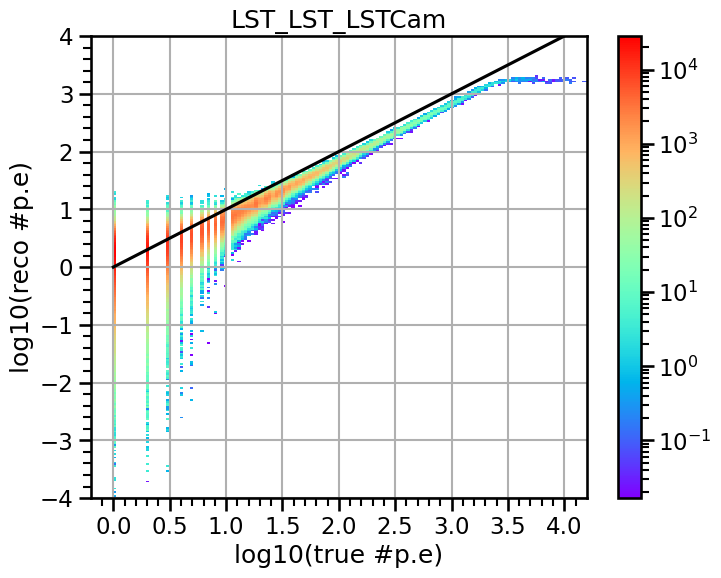

Total number of entries in the plot of MST_MST_NectarCam (before weighting) = 1417651.0


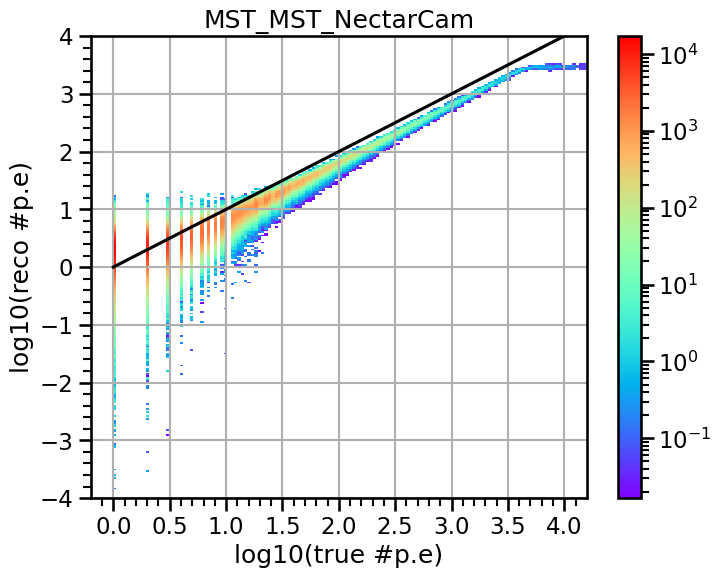

In [20]:
nbins_x = 400
nbins_y = 400

# order by telescope size, largest first
for tel_type in tel_types:

    fig = plt.figure(figsize=(single_plot_width, single_plot_height), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("log10(reco #p.e)")
    
    signal_mask = np.where((true_pixel_values[tel_type] >0) & 
                            (reco_pixel_values[tel_type] > 0))
    true = true_pixel_values[tel_type][signal_mask]
    reco = reco_pixel_values[tel_type][signal_mask]
    
    # This is just to count the real number of events given to the histogram
    h_no_weights = plt.hist2d(np.log10(true), 
                              np.log10(reco),
                              bins=[nbins_x, nbins_y],
                              range=[[-7.,5.],[-7.,5.]],
                              norm=LogNorm())
    
    # This histogram has the weights applied, 
    # which chages the number of entries
    # This is also what is plot
    h = plt.hist2d(np.log10(true),
                   np.log10(reco),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,5.],[-7.,5.]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=weights[tel_type][signal_mask])
    
    plt.plot([0, 4], [0, 4], color="black") # line showing perfect correlation
    plt.minorticks_on()
    plt.xticks(ticks=np.arange(-1, 5, 0.5), labels=["",""]+[str(i) for i in np.arange(0, 5, 0.5)])
    plt.xlim(-0.2,4.2)
    plt.ylim(-4.,4.)
    plt.colorbar(h[3], 
                 ax=plt.gca()
                )
    plt.grid()
    
    fig.savefig(f"./plots/calibration_recoPhesVsTruePhes_{tel_type}_protopipe_{analysis_name}.png")
    
    # Print some debug/benchmarking information
    print(f"Total number of entries in the plot of {tel_type} (before weighting) = {h_no_weights[0].sum()}")
    
    plt.show()

### Charge resolution
[back to top](#Table-of-contents)

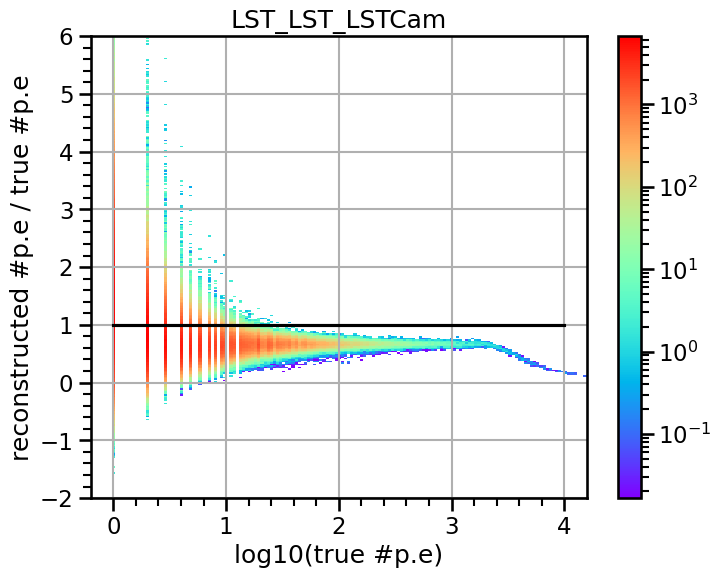

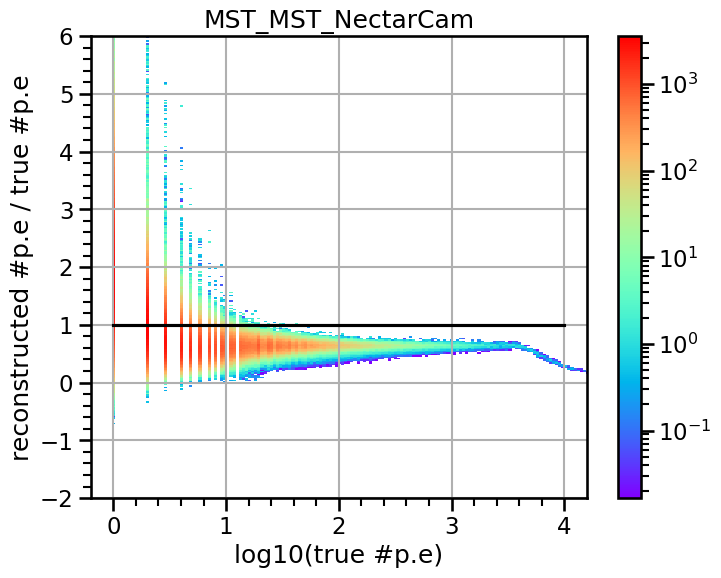

In [21]:
nbins_x = 800
nbins_y = 600

charge_resolution_histogram = {} # camera-wise un-zoomes histogram for calculating bias later on

for tel_type in tel_types:
    
    fig = plt.figure(figsize=(single_plot_width, single_plot_height), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("reconstructed #p.e / true #p.e")
    
    signal_mask = np.where(true_pixel_values[tel_type] >0)
    true = true_pixel_values[tel_type][signal_mask]
    reco = reco_pixel_values[tel_type][signal_mask]
    
    h = plt.hist2d(np.log10(true), (reco/true),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,15.],[-2,13]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=weights[tel_type][signal_mask],
                  )
    
    charge_resolution_histogram[tel_type] = h
    
    plt.plot([0, 4], [1, 1], color="black") # line showing perfect correlation
    plt.colorbar(h[3], ax=plt.gca()
                 #, format=ticker.FuncFormatter(fmt)
                )
    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor')
    plt.grid()
    plt.xlim(-0.2,4.2)
    plt.ylim(-2.,6.)

    fig.savefig(f"./plots/calibration_chargeResolution_1stPass_{tel_type}_protopipe_{analysis_name}.png")
    
    plt.show()

### Average residual bias
[back to top](#Table-of-contents)

The average bias is calculated in the range from 50 to 500 p.e. to be safely away from saturation and from NSB noise.

**NOTE:**
In the analysis pipeline this bias is not yet corrected, so the definition of what 1 photoelectron is depends on this!

In [22]:
corr = {}
print(f"Correction factors for residual average bias : ")
for tel_type in tel_types:
    corr[tel_type] = calc_bias(charge_resolution_histogram[tel_type][1],
                               charge_resolution_histogram[tel_type][2],
                               charge_resolution_histogram[tel_type][0])
    print(f"- {tel_type} = {corr[tel_type]:.2f}")

Correction factors for residual average bias : 
- LST_LST_LSTCam = 1.50
- MST_MST_NectarCam = 1.57


### Charge resolution corrected for the average residual bias
[back to top](#Table-of-contents)

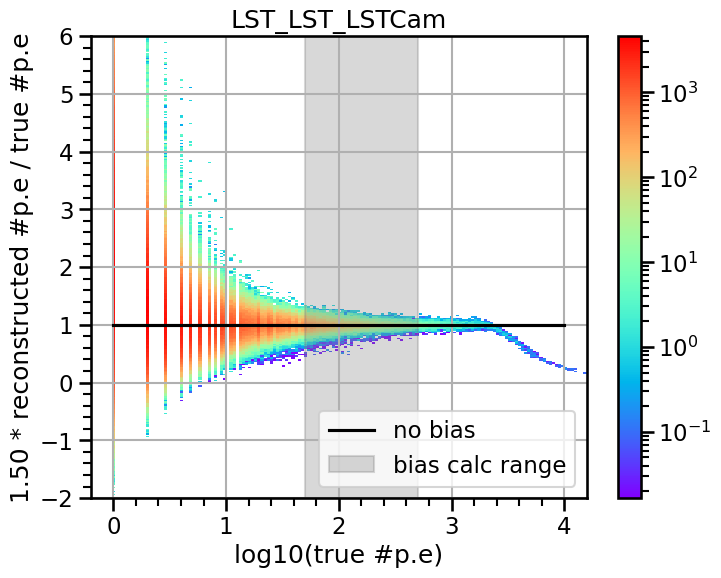

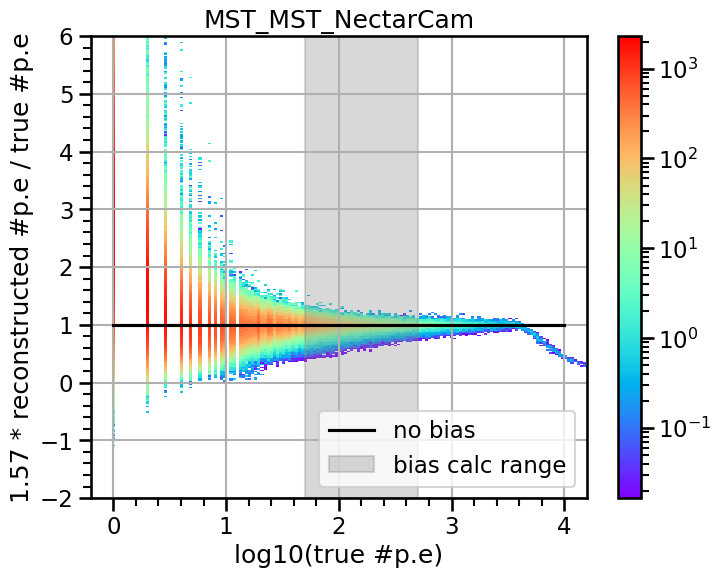

In [23]:
nbins_x = 800
nbins_y = 600

corrected_charge_resolution_histogram = {} # here we store the histograms corrected for the bias to calculate RMS in the next cell

for tel_type in tel_types:
    
    plt.figure(figsize=(single_plot_width, single_plot_height), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel(f"{corr[tel_type]:.2f} * reconstructed #p.e / true #p.e")
    
    signal_mask = np.where(true_pixel_values[tel_type] >0)
    true = true_pixel_values[tel_type][signal_mask]
    reco = reco_pixel_values[tel_type][signal_mask]
    
    h = plt.hist2d(np.log10(true), corr[tel_type]*(reco/true),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,15.],[-2,13]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=weights[tel_type][signal_mask],
                  )
    
    corrected_charge_resolution_histogram[tel_type] = h
    
    ax = plt.gca()
    plt.axvspan(np.log10(50.0), 
                np.log10(500.0), 
                ymin=ax.get_ylim()[0], 
                ymax=ax.get_ylim()[1],
                alpha = 0.3,
                color = "grey",
                label = "bias calc range")
    
    plt.plot([0, 4], [1, 1], color="black", label="no bias") # line showing perfect correlation
    plt.colorbar(h[3], ax=plt.gca()
                 #, format=ticker.FuncFormatter(fmt)
                )
    
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor')
    plt.grid()
    plt.legend(loc="lower right")
    plt.xlim(-0.2,4.2)
    plt.ylim(-2.,6.)

    plt.savefig(f"./plots/calibration_chargeResolution_1stPass_biascorrected_{tel_type}_protopipe_{analysis_name}.png")

    plt.show()

### RMS of charge resolution around 1
[back to top](#Table-of-contents)

**Warning:** CTAMARS data refers to the specific simtel file from the comparison!

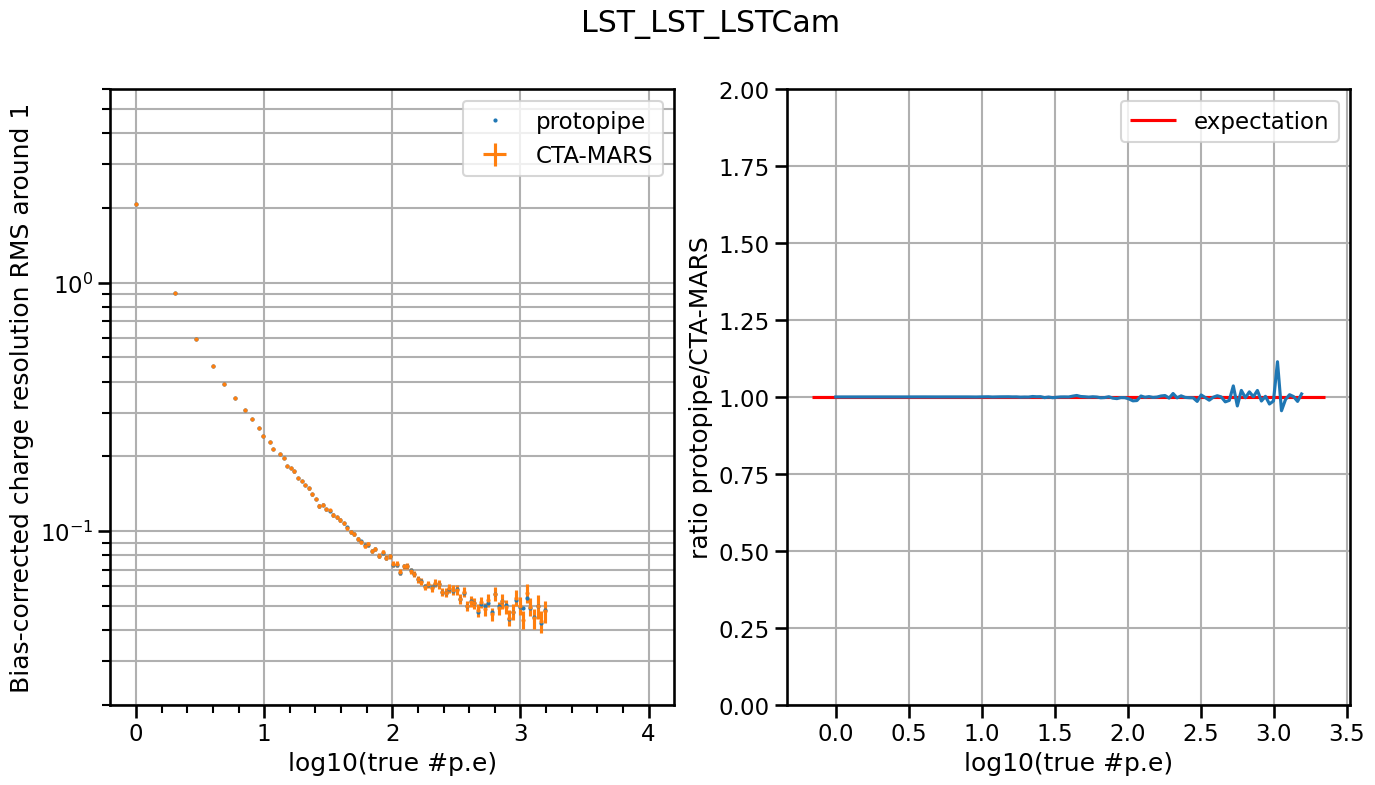

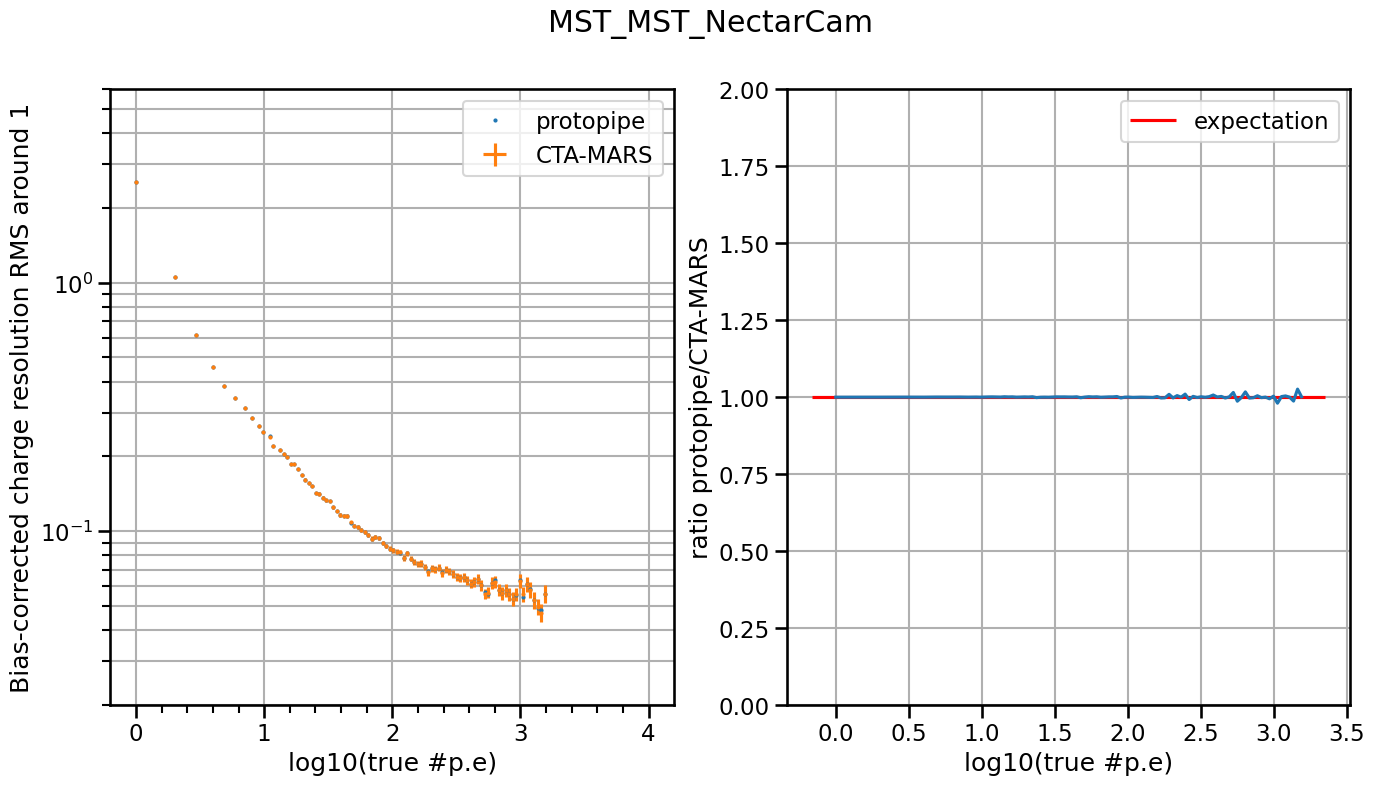

In [24]:
RMS_charge_resolution_1stPass = {}

for tel_type in tel_types:
    
    if load_CTAMARS_2019:
        fig = plt.figure(figsize=(double_plot_width, double_plot_height), tight_layout=False)
        plt.subplots_adjust(hspace=0.5)
        plt.suptitle(tel_type)
        plt.subplot(1,2,1)
    else:
        fig = plt.figure(figsize=(single_plot_width, single_plot_height), tight_layout=False)
        plt.title(tel_type)

    bin_edges_true = corrected_charge_resolution_histogram[tel_type][1]
    bincenters_true = 0.5*(bin_edges_true[1:]+bin_edges_true[:-1]) # mean value of each bin in true photoelectrons
    bin_edges_y = corrected_charge_resolution_histogram[tel_type][2] # bin edges in reconstructed photoelectrons
    bincenters_y = 0.5*(bin_edges_y[1:]+bin_edges_y[:-1]) # mean value of each bin in reconstructed photoelectrons

    # cycle over bins in true photoelectrons:
    values = []
    errors = []
    n = 0
    ref = []

    for true_bin in range(len(bincenters_true)):
        # if the bin center is over 3.2
        if (bincenters_true[true_bin] > 3.2):
            break # stop
        # if it's before -0.5
        if (bincenters_true[true_bin] < -0.5):
            continue # check the next bin
        # else proceed with the calculation
        # take the profile at this X bin along the Y axis
        profile_y = corrected_charge_resolution_histogram[tel_type][0][true_bin] # this is the sequence of weights (aka the heights of the 600 bins)
        # if there is data falling in this X-axis bin,
        if np.sum(profile_y):
            ref.append(true_bin)
            # get the resolution the way Abelardo does
            # to do this we need also the bin centers along the Y axis
            result = calc_rms(bincenters_y, profile_y)
            values.append(result)

            n = n + 1
        else: # otherwise go to the next bin in true photoelectrons
            continue

    values = np.asarray(values)
    RMS_charge_resolution_1stPass[tel_type] = values

    # protopipe
    plt.plot(bincenters_true[ref], values, 'o', markersize=2, label="protopipe")

    plt.yscale("log")
    plt.ylim(0.02,6)
    plt.xlim(-0.2,4.2)

    plt.grid(which='both', axis='y')
    plt.grid(which='major', axis='x')
    plt.minorticks_on()
    
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("Bias-corrected charge resolution RMS around 1")
    
    # CTA-MARS
    if load_CTAMARS_2019:
        
        CTAMARS_X = rms[tel_type].member("fX")
        CTAMARS_Y = rms[tel_type].member("fY")
        CTAMARS_EX = rms[tel_type].member("fEX")
        CTAMARS_EY = rms[tel_type].member("fEY")
        plt.errorbar(x = CTAMARS_X,
                     y = CTAMARS_Y, 
                     xerr = CTAMARS_EX, 
                     yerr = CTAMARS_EY,
                     fmt="o", 
                     markersize=2, 
                     label="CTA-MARS")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(CTAMARS_X, values/CTAMARS_Y)
        ax = plt.gca()
        xlims=ax.get_xlim()
        plt.hlines(1., xlims[0], xlims[1], label="expectation", color='r')
        plt.ylim(0, 2)
        plt.grid()
        plt.legend()
        plt.xlabel("log10(true #p.e)")
        plt.ylabel("ratio protopipe/CTA-MARS")

    plt.show()
    
    fig.savefig(f"./plots/calibration_chargeResolution_RMSaround1_1stPass_{tel_type}_protopipe_{analysis_name}.png")

### Performance of 2nd pass
[back to top](#Table-of-contents)

In [25]:
if not is_double_pass:
    print("This is not a double-pass image extractor.")

#### Corrected charge resolution and average residual bias
[back to top](#Table-of-contents)

In [26]:
if is_double_pass:
    
    print("""
    Ratio of reconstructed to true number of p.e. vs. true number of p.e (in a pixel)
    after the second-pass pulse integration. 
    Note that there is a small population of pixels with ~0 reconstructed signal for a relatively 
    large number of p.e. 
    These must correspond to signals which arrive out of time relative to the bulk of the image (or, alternatively, to failed time fits).

    The average residual bias should be similar to that of 1st pass, 
    since it is calculated between 50 and 500 true photoelectrons.
    """)
else:
    
    print("This is not a double-pass image extractor.")


    Ratio of reconstructed to true number of p.e. vs. true number of p.e (in a pixel)
    after the second-pass pulse integration. 
    Note that there is a small population of pixels with ~0 reconstructed signal for a relatively 
    large number of p.e. 
    These must correspond to signals which arrive out of time relative to the bulk of the image (or, alternatively, to failed time fits).

    The average residual bias should be similar to that of 1st pass, 
    since it is calculated between 50 and 500 true photoelectrons.
    


In [27]:
# Calculate bias for 2nd pass (if any)
if is_double_pass:
    
    nbins_x = 800
    nbins_y = 600

    charge_resolution_2ndPass_histogram = {} # camera-wise un-zoomes histogram for calculating bias later on

    for tel_type in tel_types:

        signal_mask = np.where((true_pixel_values_2ndPass[tel_type] >0))

        true = true_pixel_values_2ndPass[tel_type][signal_mask]
        reco = reco_pixel_values_2ndPass[tel_type][signal_mask]

        h_2ndPass = np.histogram2d(np.log10(true), (reco/true),
                                   bins=[nbins_x, nbins_y],
                                   range=[[-7.,15.],[-2,13]],
                                   weights=weights[tel_type][signal_mask],
                                  )

        charge_resolution_2ndPass_histogram[tel_type] = h_2ndPass

    corr_2ndPass = {}
    print(f"Correction factors for residual average bias (2nd pass) : ")
    for tel_type in tel_types:
        corr_2ndPass[tel_type] = calc_bias(charge_resolution_2ndPass_histogram[tel_type][1],
                                           charge_resolution_2ndPass_histogram[tel_type][2],
                                           charge_resolution_2ndPass_histogram[tel_type][0])
        print(f"- {tel_type} = {corr_2ndPass[tel_type]:.2f}")
else:
    
    print("This is not a double-pass image extractor.")

Correction factors for residual average bias (2nd pass) : 
- LST_LST_LSTCam = 1.54
- MST_MST_NectarCam = 1.66


#### RMS of charge resolution around 1
[back to top](#Table-of-contents)

In [28]:
if is_double_pass:

    nbins_x = 800
    nbins_y = 600

    corrected_charge_2ndPass_resolution_histogram = {} # here we store the histograms corrected for the bias to calculate RMS in the next cell

    for tel_type in tel_types:

        fig = plt.figure(figsize=(single_plot_width, single_plot_height), tight_layout=False)

        plt.title(tel_type)
        plt.xlabel("log10(true #p.e)")
        plt.ylabel(f"{corr_2ndPass[tel_type]:.2f} * reconstructed #p.e / true #p.e")

        signal_mask = np.where((true_pixel_values_2ndPass[tel_type] >0))

        true = true_pixel_values_2ndPass[tel_type][signal_mask]
        reco = reco_pixel_values_2ndPass[tel_type][signal_mask]

        h = plt.hist2d(np.log10(true), corr_2ndPass[tel_type]*(reco/true),
                       bins=[nbins_x, nbins_y],
                       range=[[-7.,15.],[-2,13]],
                       norm=LogNorm(),
                       cmap=plt.cm.rainbow,
                       weights=weights[tel_type][signal_mask],
                      )

        corrected_charge_2ndPass_resolution_histogram[tel_type] = h

        ax = plt.gca()
        plt.axvspan(np.log10(50.0), 
                    np.log10(500.0), 
                    ymin=ax.get_ylim()[0], 
                    ymax=ax.get_ylim()[1],
                    alpha = 0.3,
                    color = "grey",
                    label = "bias calc range")

        plt.plot([0, 4], [1, 1], color="black", label="no bias") # line showing perfect correlation
        plt.colorbar(h[3], ax=plt.gca()
                     #, format=ticker.FuncFormatter(fmt)
                    )

        ax.minorticks_on()
        ax.tick_params(axis='x', which='minor')
        plt.grid()
        plt.legend(loc="lower right")
        plt.xlim(-0.2,4.2)
        plt.ylim(-2.,6.)

        fig.savefig(f"./plots/calibration_chargeResolution_2ndPass_biascorrected_{tel_type}_protopipe_{analysis_name}.png")

else:
    
    print("This is not a double-pass image extractor.")

#### RMS around 1 comparison between passes
[back to top](#Table-of-contents)

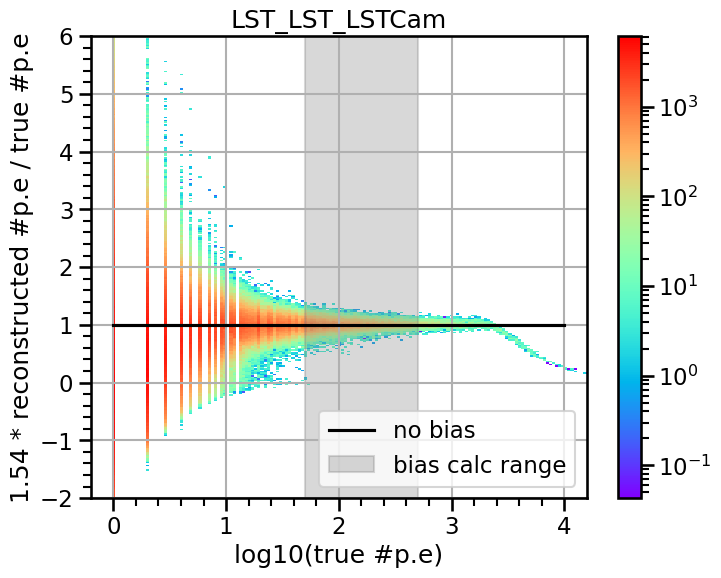

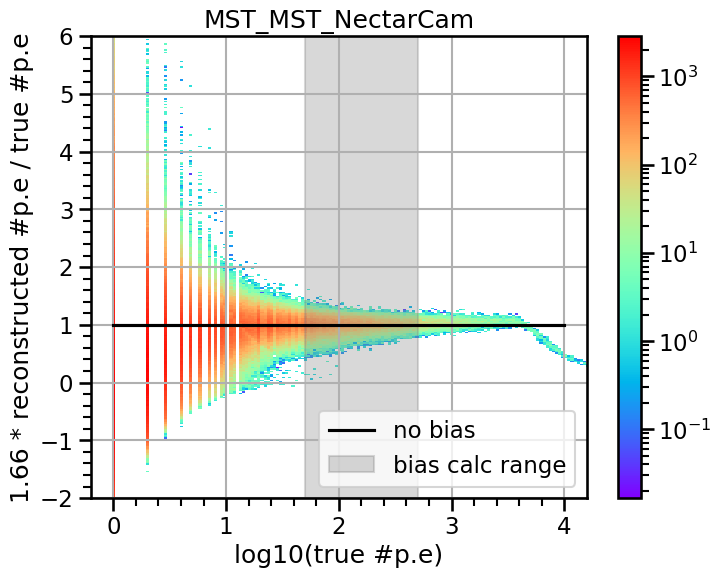

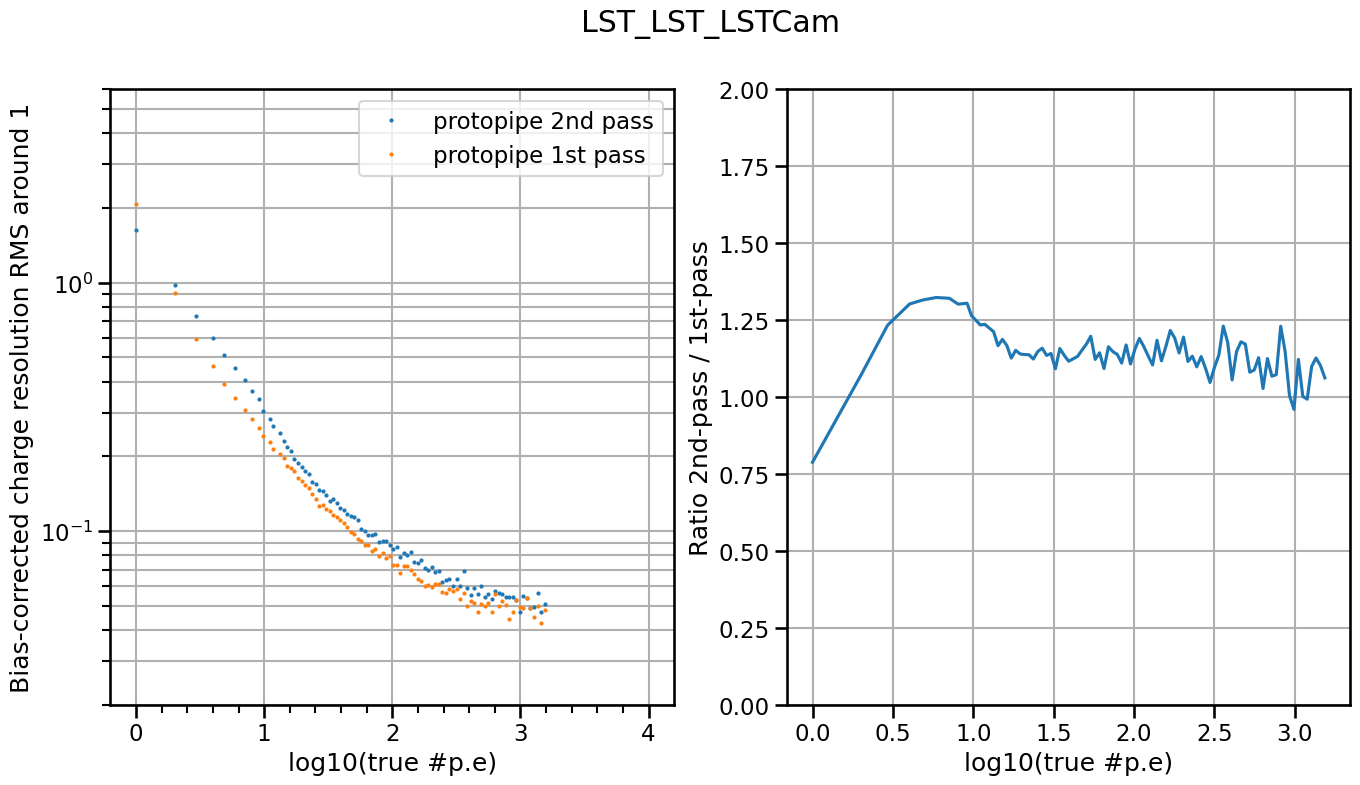

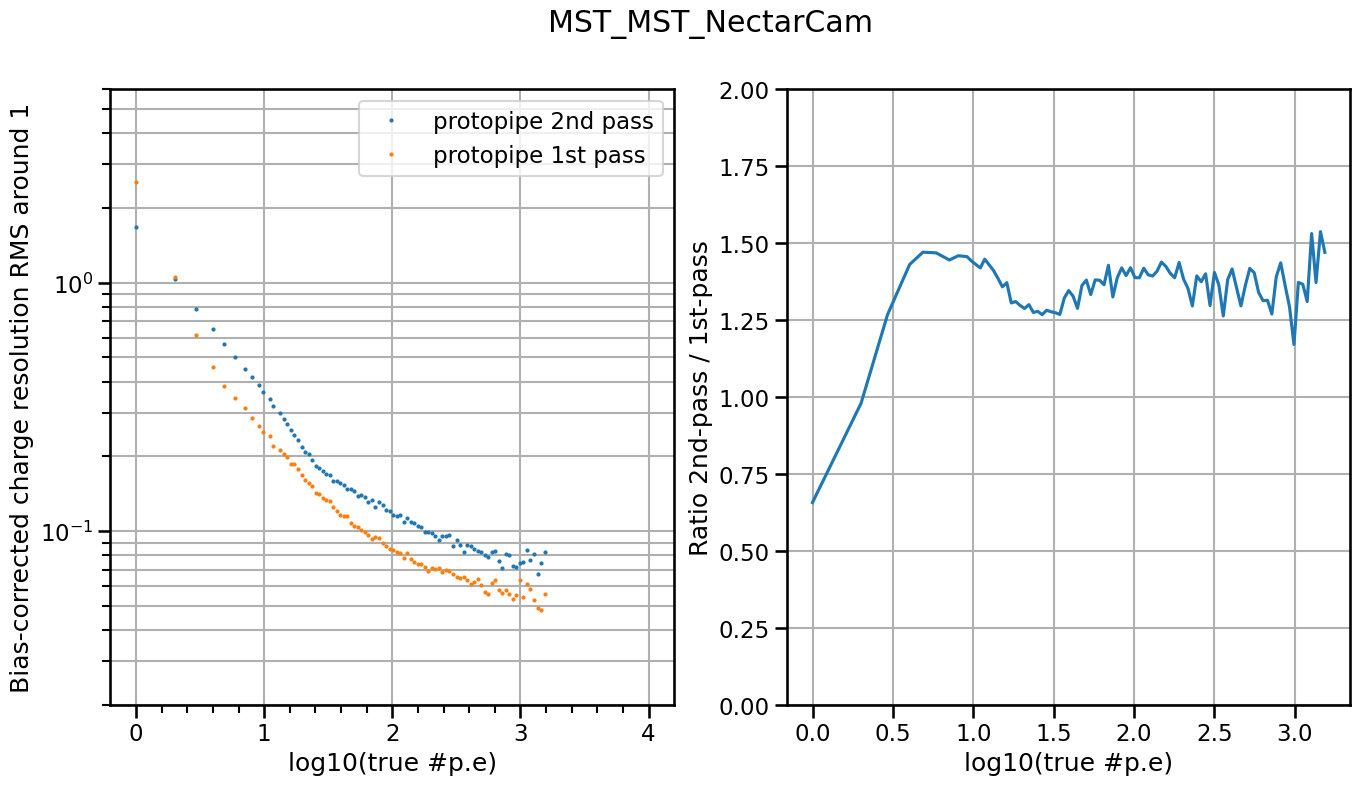

In [29]:
if is_double_pass:
    
    for tel_type in tel_types:
    
        fig = plt.figure(figsize=(double_plot_width, double_plot_height), tight_layout=False)
        plt.subplots_adjust(hspace=0.4)
        plt.suptitle(tel_type)

        plt.subplot(1,2,1)

        bin_edges_true = corrected_charge_2ndPass_resolution_histogram[tel_type][1]
        bincenters_true = 0.5*(bin_edges_true[1:]+bin_edges_true[:-1]) # mean value of each bin in true photoelectrons
        bin_edges_y = corrected_charge_2ndPass_resolution_histogram[tel_type][2] # bin edges in reconstructed photoelectrons
        bincenters_y = 0.5*(bin_edges_y[1:]+bin_edges_y[:-1]) # mean value of each bin in reconstructed photoelectrons

        # cycle over bins in true photoelectrons:
        values = []
        errors = []
        n = 0
        ref = []

        for true_bin in range(len(bincenters_true)):
            # if the bin center is over 3.2
            if (bincenters_true[true_bin] > 3.2):
                break # stop
            # if it's before -0.5
            if (bincenters_true[true_bin] < -0.5):
                continue # check the next bin
            # else proceed with the calculation
            # take the profile at this X bin along the Y axis
            profile_y = corrected_charge_2ndPass_resolution_histogram[tel_type][0][true_bin] # this is the sequence of weights (aka the heights of the 600 bins)
            # if there is data falling in this X-axis bin,
            if np.sum(profile_y):
                ref.append(true_bin)
                # get the resolution the way Abelardo does
                # to do this we need also the bin centers along the Y axis
                result = calc_rms(bincenters_y, profile_y)
                values.append(result)

                n = n + 1
            else: # otherwise go to the next bin in true photoelectrons
                continue

        values = np.asarray(values)

        # protopipe
        plt.plot(bincenters_true[ref], values, 'o', markersize=2, label="protopipe 2nd pass")

        plt.yscale("log")
        plt.ylim(0.02,6)
        plt.xlim(-0.2,4.2)

        plt.grid(which='both', axis='y')
        plt.grid(which='major', axis='x')
        plt.minorticks_on()

        plt.xlabel("log10(true #p.e)")
        plt.ylabel("Bias-corrected charge resolution RMS around 1")

        plt.plot(bincenters_true[ref], RMS_charge_resolution_1stPass[tel_type], 'o', markersize=2, label="protopipe 1st pass")
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bincenters_true[ref], values/RMS_charge_resolution_1stPass[tel_type])
        #ax = plt.gca()
        #xlims=ax.get_xlim()
        #plt.hlines(1., xlims[0], xlims[1], label="expectation", color='r')
        plt.ylim(0, 2)
        plt.grid()
        #plt.legend()
        plt.xlabel("log10(true #p.e)")
        plt.ylabel("Ratio 2nd-pass / 1st-pass")

        plt.show()

        fig.savefig(f"./plots/calibration_chargeResolution_RMSaround1_1stvs2ndPass_{tel_type}_protopipe_{analysis_name}.png")
        
else:
    
    print("This is not a double-pass image extractor.")

#### Comparison of charge resolution y-profiles between passes
[back to top](#Table-of-contents)

LST_LST_LSTCam
Ratio 2ndPass vs 1st pass around 0.1 log10(true phe) = 1.07
Ratio 2ndPass vs 1st pass around 0.4 log10(true phe) = 1.23
Ratio 2ndPass vs 1st pass around 0.7 log10(true phe) = 1.32
Ratio 2ndPass vs 1st pass around 1 log10(true phe) = 1.23


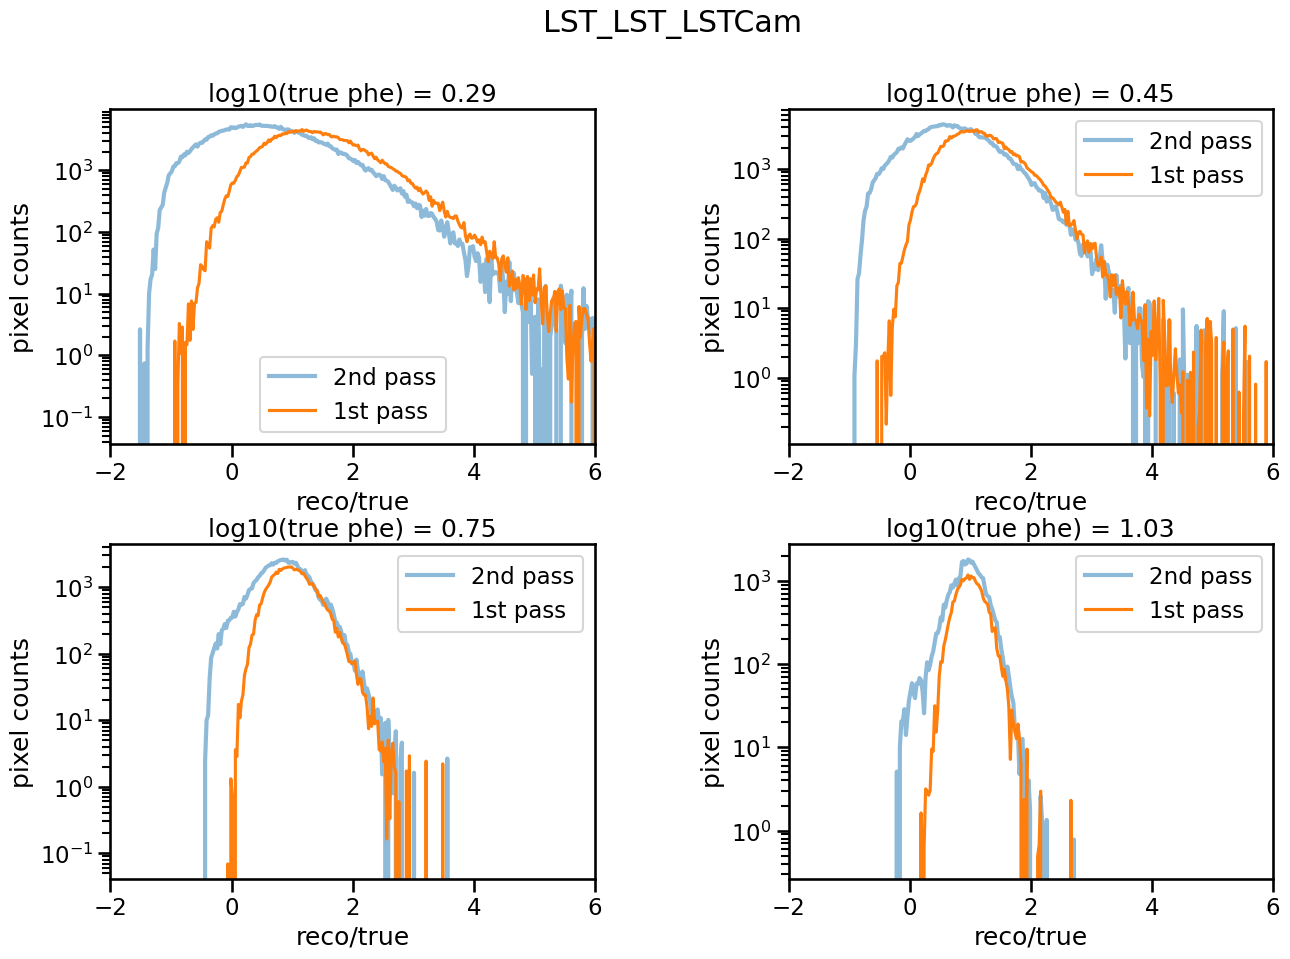

MST_MST_NectarCam
Ratio 2ndPass vs 1st pass around 0.1 log10(true phe) = 0.98
Ratio 2ndPass vs 1st pass around 0.4 log10(true phe) = 1.27
Ratio 2ndPass vs 1st pass around 0.7 log10(true phe) = 1.47
Ratio 2ndPass vs 1st pass around 1 log10(true phe) = 1.42


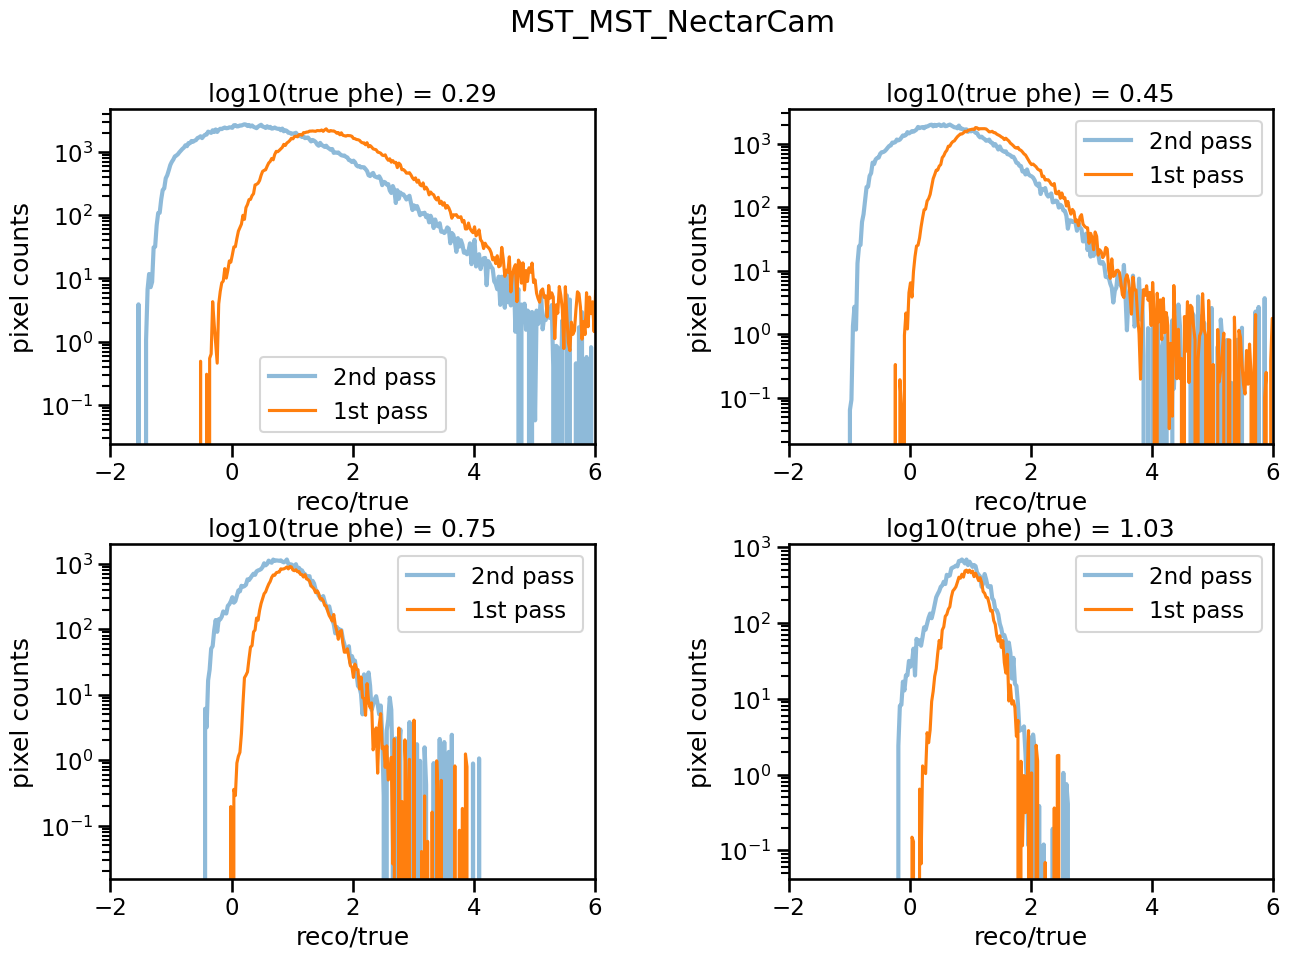

In [30]:
if is_double_pass:

    for tel_type in tel_types:
        
        print(tel_type)

        first_pass = corrected_charge_resolution_histogram[tel_type]
        second_pass = corrected_charge_2ndPass_resolution_histogram[tel_type]

        bin_edges_true = first_pass[1][np.where((first_pass[1] > -0.5) & (first_pass[1] < 3.2))[0]]
        bincenters_true = 0.5*(bin_edges_true[1:]+bin_edges_true[:-1])

        values = [0.1,0.4,0.7,1] # make the plot for the bin around here

        plt.figure(figsize=(15,10))
        plt.suptitle(tel_type)
        plt.subplots_adjust(wspace=0.4, hspace=0.3)

        for i, value in enumerate(values):

            plt.subplot(int(np.sqrt(len(values))), int(np.sqrt(len(values))), i+1)

            true_index = np.digitize(value,second_pass[1])
            while not (np.sum(second_pass[0][true_index][:]) and np.sum(second_pass[0][true_index][:])):
                true_index +=1

            x_centers = 0.5 * (first_pass[2][1:]+
                              first_pass[2][:-1])

            plt.plot(x_centers, second_pass[0][true_index][:], label=f"2nd pass", lw=3, alpha=0.5)
            plt.plot(x_centers, first_pass[0][true_index][:], label=f"1st pass")
            plt.legend()
            plt.xlabel("reco/true")
            plt.ylabel("pixel counts")
            plt.yscale("log")
            plt.xlim(-2,6.)

            plt.title(f"log10(true phe) = {second_pass[1][true_index]:.2f}")

            RMS_2 = calc_rms(x_centers, second_pass[0][true_index][:])
            RMS_1 = calc_rms(x_centers, first_pass[0][true_index][:])
            ratio = RMS_2 / RMS_1
            print(f"Ratio 2ndPass vs 1st pass around {value} log10(true phe) = {ratio:.2f}")
            
        plt.show()

else:
    
    print("This is not a double-pass image extractor.")

### Single-pixels spectra and optimized cleaning thresholds
[back to top](#Table-of-contents)

In [31]:
CTAMARS_spectrum_1stPass_path = indir_CTAMARS / "pixspec_1st_pass.root"
CTAMARS_spectrum_2ndPass_path = indir_CTAMARS / "pixspec_2nd_pass.root"

CTAMARS_spectrum_1stPass = {}
with uproot.open(CTAMARS_spectrum_1stPass_path) as file:
    CTAMARS_spectrum_1stPass["LST_LST_LSTCam"] = file["hPixAmpl_integral_type_0"]
    CTAMARS_spectrum_1stPass["MST_MST_NectarCam"] = file["hPixAmpl_integral_type_1"]

CTAMARS_spectrum_2ndPass = {}
with uproot.open(CTAMARS_spectrum_2ndPass_path) as file:
    CTAMARS_spectrum_2ndPass["LST_LST_LSTCam"] = file["hPixAmpl_integral_type_0"]
    CTAMARS_spectrum_2ndPass["MST_MST_NectarCam"] = file["hPixAmpl_integral_type_1"]

**NOTE:**

- If the image extractor uses a double-pass approach, the bias for the cut values calculated from the 2nd pass is calculated from 2nd pass reconstructed charges.
  
  Said this, image extractors such as ``TwoPassWindowSum`` are meant to be effective on weak charges, and the bias is anyway calculated between 50 and 500 true p.e. so the difference should be rather small if not insignificant with respect to the bias calculated from the 1st pass.

- The optimized cleaning threshlods build upon the definition of what "1 photoelectron" means.

  If there is residual bias from the image extraction process and the pipeline _doesn't_ account for it _before_ the image cleaning process, then the **biased** values are the correct ones to be used throughout the analysis.

  The **unbiased** values are to be used if the residual bias is neglibile and in any case in the comparison between other pipelines/analyses when their bias is not known.


Optimized cleaning thresholds for LST_LST_LSTCam

Method #1: fixing y=1.e-2 (as it is done in CTAMARS)
- BIASED definition
4.17 phe
- UN-BIASED definition
6.40 phe

Method #2: noise rejection
- BIASED definition
3.37 p.e. for 99.0% noise rejection
- UN-BIASED definition
5.17 p.e. for 99.0% noise rejection


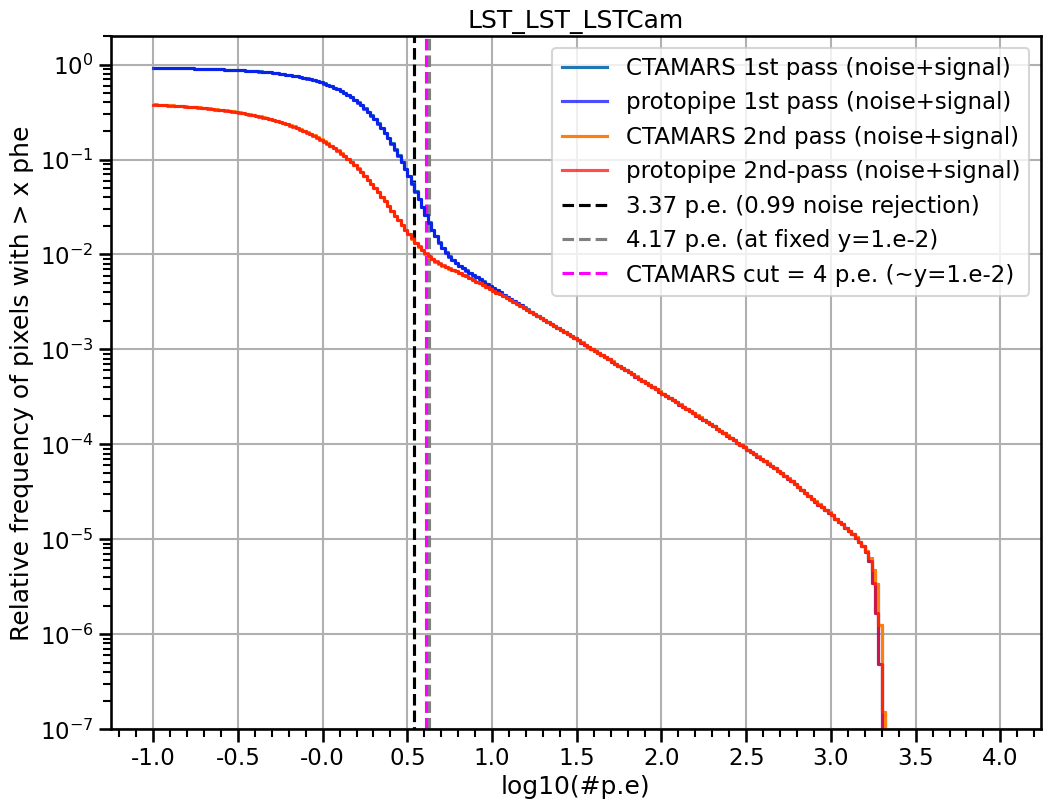


Optimized cleaning thresholds for MST_MST_NectarCam

Method #1: fixing y=1.e-2 (as it is done in CTAMARS)
- BIASED definition
3.98 phe
- UN-BIASED definition
6.63 phe

Method #2: noise rejection
- BIASED definition
3.20 p.e. for 99.0% noise rejection
- UN-BIASED definition
5.32 p.e. for 99.0% noise rejection


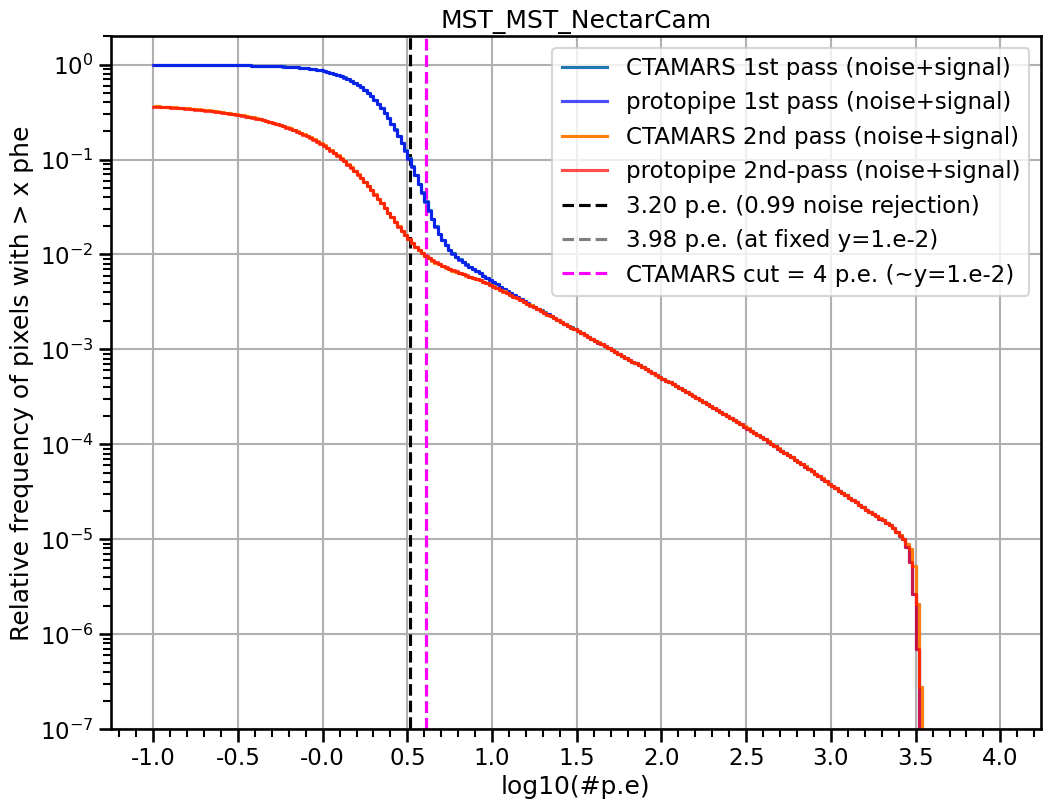

In [32]:
for tel_type in sorted(tel_types):
    
    fig = plt.figure(figsize=(1.5*single_plot_width, 1.5*single_plot_height), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(#p.e)")
    plt.ylabel("Relative frequency of pixels with > x phe")
    
    x_bin_edges = CTAMARS_spectrum_1stPass[tel_type].to_numpy()[1]
    xrange = [min(x_bin_edges), max(x_bin_edges)]
    
    true = true_pixel_values[tel_type]
    total_entries = len(true)
    
    log_mask = reco_pixel_values[tel_type] > 0
    reco = reco_pixel_values[tel_type][log_mask]
    signal = reco[true[log_mask] > 0]
    noise = reco[true[log_mask] == 0]
    if is_double_pass:
        true_2 = true_pixel_values_2ndPass[tel_type]
        log_mask_2 = reco_pixel_values_2ndPass[tel_type] > 0
        reco_2 = reco_pixel_values_2ndPass[tel_type][log_mask_2]
        signal_2 = reco_2[true_2[log_mask_2] > 0]
        noise_2 = reco_2[true_2[log_mask_2] == 0]
        
    # Plot 1st-Pass (or unique pass if not a double-pass image extractor)
    
    # CTAMARS
    if load_CTAMARS_2019:
        plt.step(x = 0.5 * (x_bin_edges[1:] + x_bin_edges[:-1]),
                 y = CTAMARS_spectrum_1stPass[tel_type].to_numpy()[0],
                 where = "mid",
                 label="CTAMARS 1st pass (noise+signal)")
    
    # protopipe
    X, Y = plot_spectrum(reco,
                  x_bin_edges,
                  total_entries,
                  xrange,
                  drawstyle="steps-post",
                  alpha=0.7,
                  label="protopipe 1st pass (noise+signal)", 
                  color='blue')
    
    # Plot only signal
    
    #plot_spectrum(signal,
    #              x_bin_edges,
    #              total_entries,
    #              xrange,
    #              drawstyle="steps-post",
    #              alpha=0.7,
    #              label="protopipe signal",
    #              ls="dotted",
    #              color='blue')
    
    # Plot only noise
    
    #plot_spectrum(noise,
    #              x_bin_edges,
    #              total_entries,
    #              xrange,
    #              drawstyle="steps-post",
    #              alpha=0.7,
    #              label="protopipe noise", 
    #              ls="dashed",
    #              color='blue')
    
    if is_double_pass:
        
        # Plot 2nd-pass
        
        # CTAMARS
        if load_CTAMARS_2019:
            plt.step(x = 0.5 * (x_bin_edges[1:] + x_bin_edges[:-1]),
                     y = CTAMARS_spectrum_2ndPass[tel_type].to_numpy()[0],
                     where = "mid",
                     label="CTAMARS 2nd pass (noise+signal)")
        
        # protopipe
        X, Y = plot_spectrum(reco_2,
                      x_bin_edges,
                      total_entries,
                      xrange,
                      drawstyle="steps-post",
                      alpha=0.7,
                      label="protopipe 2nd-pass (noise+signal)", 
                      color='red')
        
        # Plot only signal
    
        #plot_spectrum(signal_2,
        #              x_bin_edges,
        #              total_entries,
        #              xrange,
        #              drawstyle="steps-post",
        #              alpha=0.7,
        #              label="protopipe 2nd pass signal", 
        #              ls="dotted",
        #              color='red')
        
        # Plot only noise
    
        #plot_spectrum(noise_2,
        #              x_bin_edges,
        #              total_entries,
        #              xrange,
        #              drawstyle="steps-post",
        #              alpha=0.7,
        #              label="protopipe 2nd pass noise", 
        #              ls="dashed",
        #              color='red')
     
    if is_double_pass:
        quantile = np.quantile(noise_2, noise_rejection_level)
    else:
        quantile = np.quantile(noise, noise_rejection_level)
    
    plt.vlines(np.log10(quantile),
               ymin = plt.gca().get_ylim()[0],
               ymax = plt.gca().get_ylim()[1],
               color="black",
               label=f"{quantile:.2f} p.e. ({noise_rejection_level} noise rejection)",
               ls="dashed"
               )
    
    plt.minorticks_on()
    plt.ylim(1.e-7, 2.)
    plt.xticks(np.arange(min(xrange), max(xrange)+1, 0.5))
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    plt.grid()
    
    print(f"\nOptimized cleaning thresholds for {tel_type}")
    
    print(f"\nMethod #1: fixing y=1.e-2 (as it is done in CTAMARS)")
    y_values = Y
    idx = (np.abs(y_values - 1.e-2)).argmin()
    x = 0.5 * (x_bin_edges[1:] + x_bin_edges[:-1])
    cut = 10**X[idx]
    
    print("- BIASED definition")
    print(f"{cut:.2f} phe")
    print("- UN-BIASED definition")
    if is_double_pass:
        print(f"{cut * corr_2ndPass[tel_type]:.2f} phe")
    else:
        print(f"{cut * corr[tel_type]:.2f} phe")
    
    plt.vlines(X[idx],
               ymin = plt.gca().get_ylim()[0],
               ymax = plt.gca().get_ylim()[1],
               color="grey",
               label=f"{10**X[idx]:.2f} p.e. (at fixed y=1.e-2)",
               ls="dashed"
               )

    plt.vlines(np.log10(4.0),
               ymin = plt.gca().get_ylim()[0],
               ymax = plt.gca().get_ylim()[1],
               color="magenta",
               label="CTAMARS cut = 4 p.e. (~y=1.e-2)",
               ls="dashed"
               )

    plt.legend(loc="best")
    
    
    print(f"\nMethod #2: noise rejection")
    print("- BIASED definition")
    print(f"{quantile:.2f} p.e. for {noise_rejection_level*100}% noise rejection")
    print("- UN-BIASED definition")
    if is_double_pass:
        print(f"{quantile*corr_2ndPass[tel_type]:.2f} p.e. for {noise_rejection_level*100}% noise rejection")
    else:
        print(f"{quantile*corr[tel_type]:.2f} p.e. for {noise_rejection_level*100}% noise rejection")
        
    plt.show()
    
    fig.savefig(f"./plots/calibration_SinglePixelSpectrum_{tel_type}_protopipe_{analysis_name}.png")

#### Comparison between 1st or single passes
[back to top](#Table-of-contents)

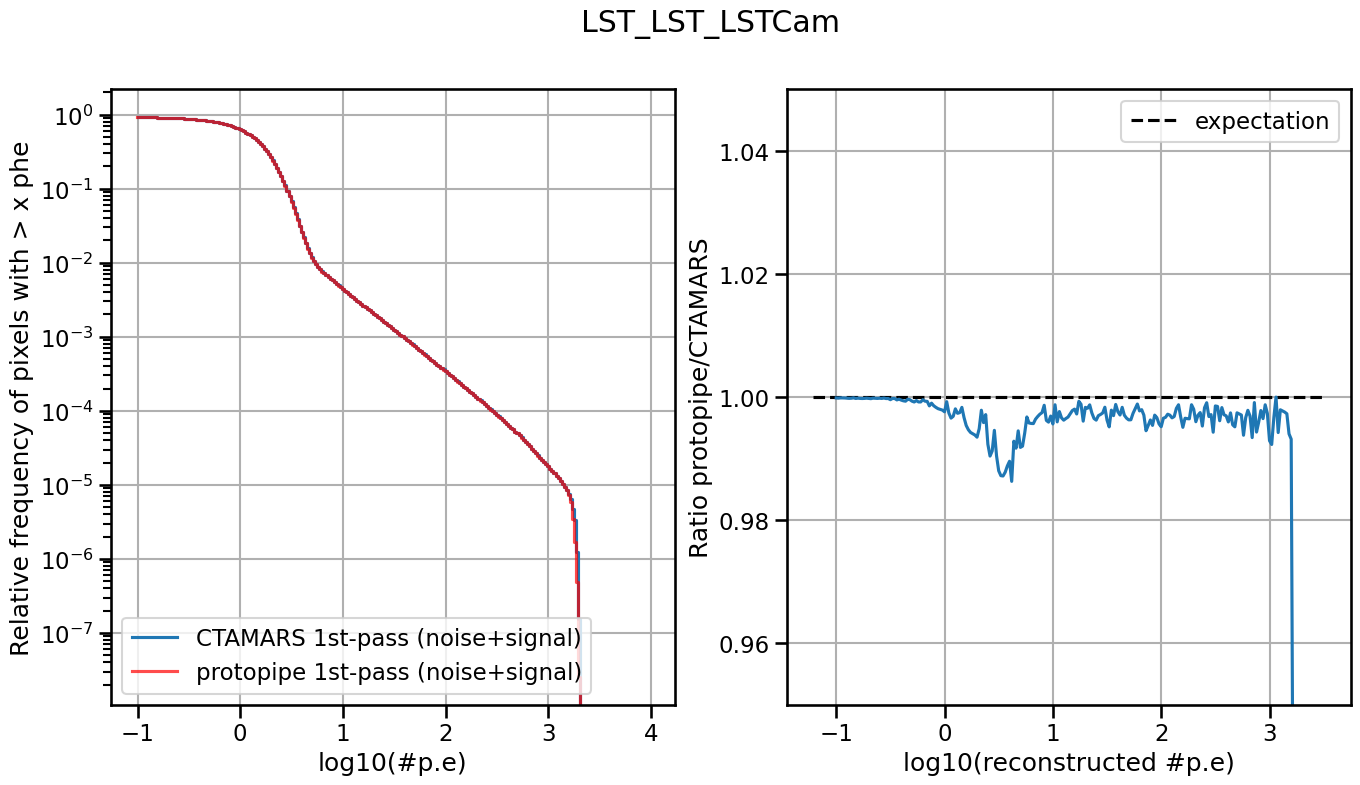

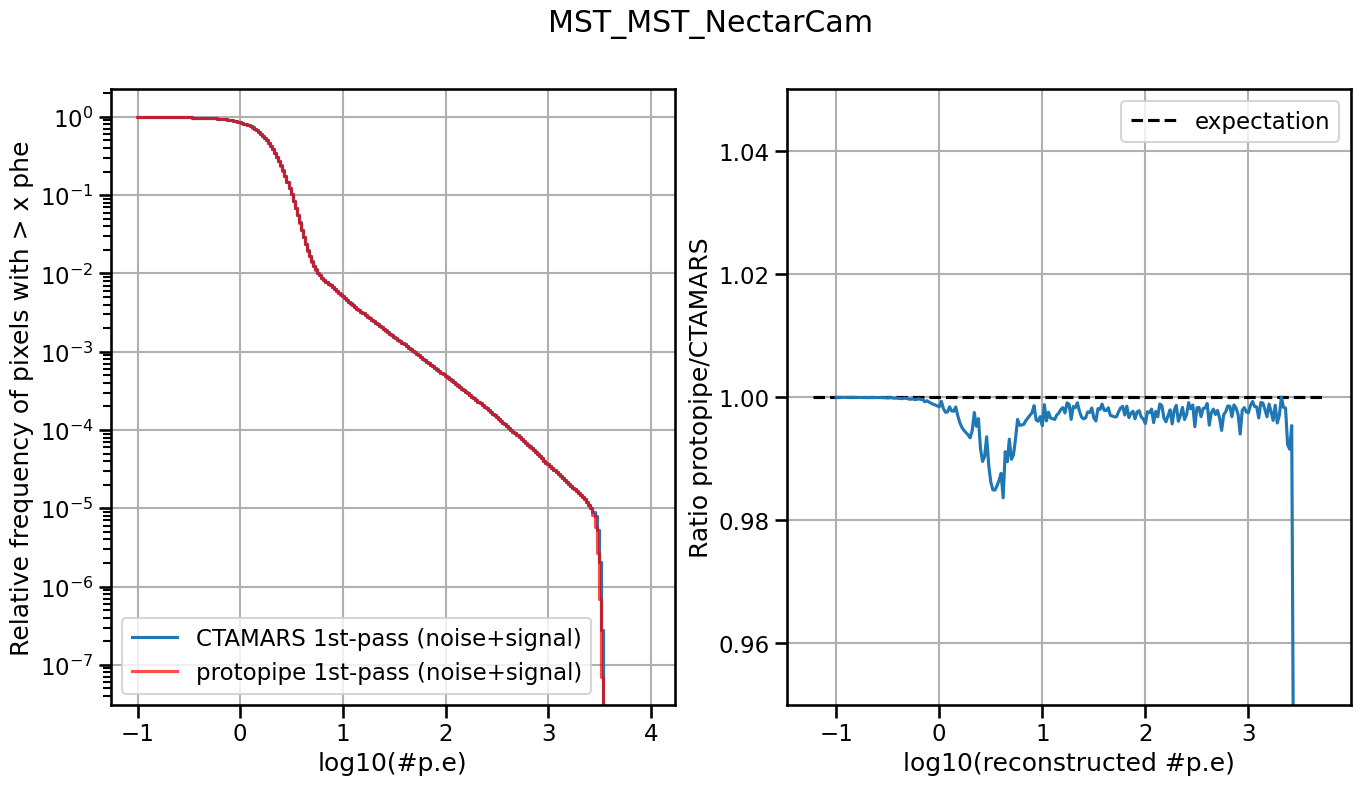

In [33]:
if load_CTAMARS_2019:

    for tel_type in sorted(tel_types):

        fig = plt.figure(figsize=(double_plot_width, double_plot_height), tight_layout=False)
        plt.subplots_adjust(hspace=0.4)

        plt.suptitle(tel_type)

        plt.subplot(1, 2, 1)

        plt.xlabel("log10(#p.e)")
        plt.ylabel("Relative frequency of pixels with > x phe")

        x_bin_edges = CTAMARS_spectrum_1stPass[tel_type].to_numpy()[1]
        xrange = [min(x_bin_edges), max(x_bin_edges)]

        true = true_pixel_values[tel_type]
        total_entries = len(true)

        log_mask = reco_pixel_values[tel_type] > 0
        reco = reco_pixel_values[tel_type][log_mask]

        # Plot 1st-pass

        # CTAMARS
        plt.step(x = 0.5 * (x_bin_edges[1:] + x_bin_edges[:-1]),
                 y = CTAMARS_spectrum_1stPass[tel_type].to_numpy()[0],
                 where = "mid",
                 label="CTAMARS 1st-pass (noise+signal)")

        # protopipe
        X, Y = plot_spectrum(reco,
                      x_bin_edges,
                      total_entries,
                      xrange,
                      drawstyle="steps-post",
                      alpha=0.7,
                      label="protopipe 1st-pass (noise+signal)", 
                      color='red')
        
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.xlabel("log10(reconstructed #p.e)")
        plt.ylabel("Ratio protopipe/CTAMARS")
        ratio = Y/CTAMARS_spectrum_1stPass[tel_type].to_numpy()[0]
        plt.plot(0.5 * (x_bin_edges[1:] + x_bin_edges[:-1]), ratio)
        ax = plt.gca()
        xlims=ax.get_xlim()
        plt.hlines(1.0, xmin=min(xlims), xmax=max(xlims), label="expectation", ls="dashed", color="black")
        #plt.hlines(1.025, xmin=min(xlims), xmax=max(xlims), alpha=0.5, label="1.025", ls="dashed", color="red")
        plt.ylim(0.95, 1.05)
        plt.grid()
        plt.legend()
        
        plt.show()

else:
    
    print("No reference data (CTAMARS) was not provided")

#### Comparison between 2nd passes
[back to top](#Table-of-contents)

In [34]:
if not is_double_pass:
    print("This is not a double-pass image extractor.")

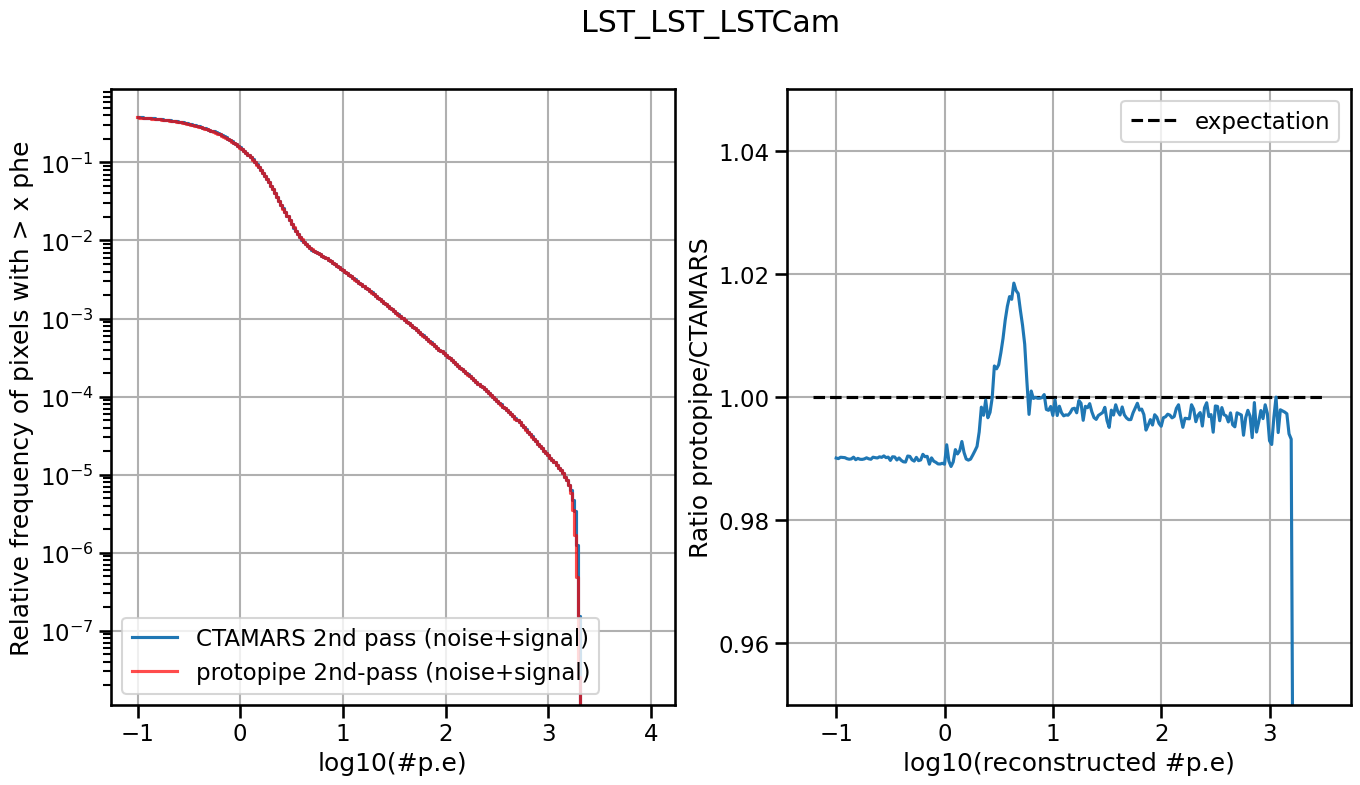

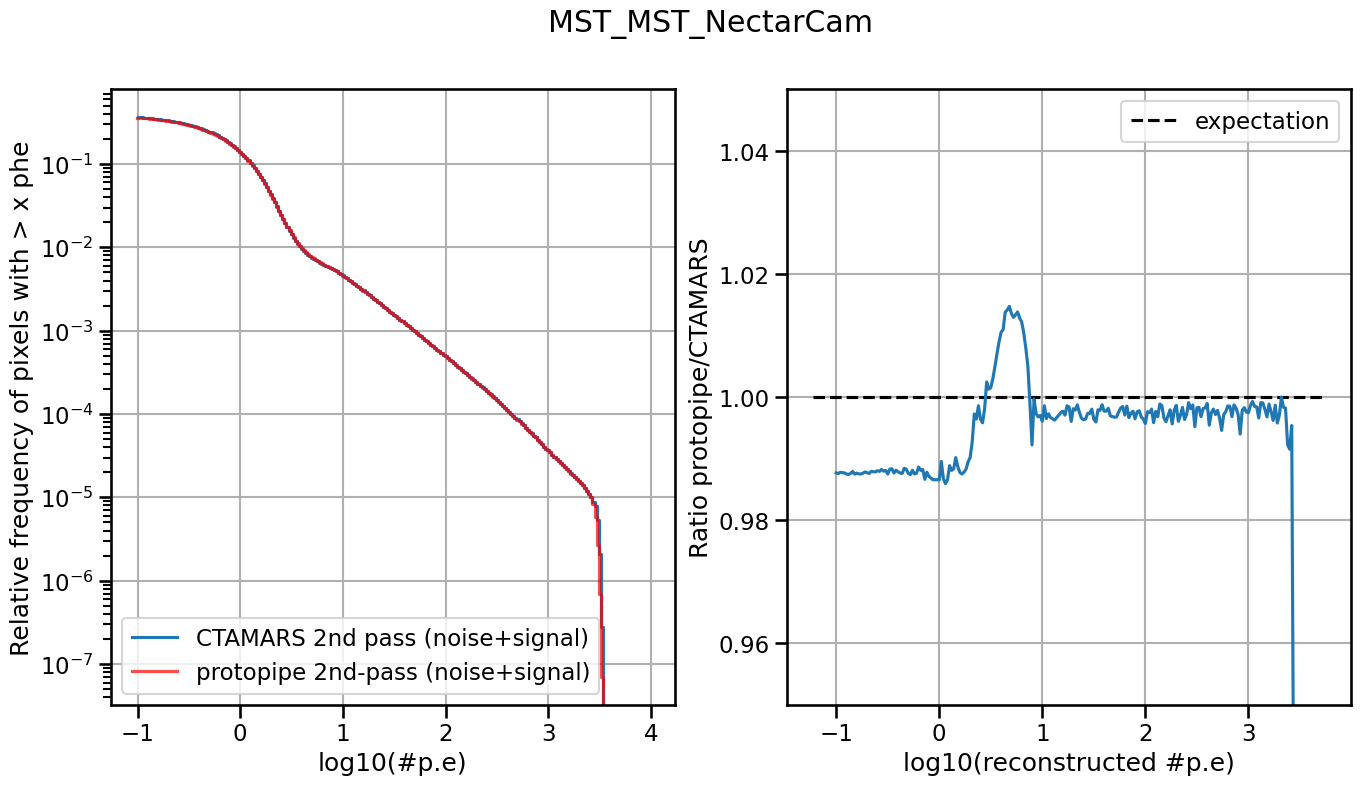

In [35]:
if is_double_pass and load_CTAMARS_2019:

    for tel_type in sorted(tel_types):

        fig = plt.figure(figsize=(double_plot_width, double_plot_height), tight_layout=False)
        plt.subplots_adjust(hspace=0.4)

        plt.suptitle(tel_type)

        plt.subplot(1, 2, 1)

        plt.xlabel("log10(#p.e)")
        plt.ylabel("Relative frequency of pixels with > x phe")

        x_bin_edges = CTAMARS_spectrum_1stPass[tel_type].to_numpy()[1]
        xrange = [min(x_bin_edges), max(x_bin_edges)]

        true = true_pixel_values[tel_type]
        total_entries = len(true)

        log_mask_2 = reco_pixel_values_2ndPass[tel_type] > 0
        reco_2 = reco_pixel_values_2ndPass[tel_type][log_mask_2]

        # Plot 2nd-pass

        # CTAMARS
        plt.step(x = 0.5 * (x_bin_edges[1:] + x_bin_edges[:-1]),
                 y = CTAMARS_spectrum_2ndPass[tel_type].to_numpy()[0],
                 where = "mid",
                 label="CTAMARS 2nd pass (noise+signal)")

        # protopipe
        X, Y = plot_spectrum(reco_2,
                      x_bin_edges,
                      total_entries,
                      xrange,
                      drawstyle="steps-post",
                      alpha=0.7,
                      label="protopipe 2nd-pass (noise+signal)", 
                      color='red')
        
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.xlabel("log10(reconstructed #p.e)")
        plt.ylabel("Ratio protopipe/CTAMARS")
        ratio = Y/CTAMARS_spectrum_2ndPass[tel_type].to_numpy()[0]
        plt.plot(0.5 * (x_bin_edges[1:] + x_bin_edges[:-1]), ratio)
        ax = plt.gca()
        xlims=ax.get_xlim()
        plt.hlines(1.0, xmin=min(xlims), xmax=max(xlims), label="expectation", ls="dashed", color="black")
        #plt.hlines(1.025, xmin=min(xlims), xmax=max(xlims), alpha=0.5, label="1.025", ls="dashed", color="red")
        plt.ylim(0.95, 1.05)
        plt.grid()
        plt.legend()

        plt.show()

else:
    
    print("This is not a double-pass image extractor OR CTAMARS data is unavailable.")

#### Comparison between true and reconstructed spectra
[back to top](#Table-of-contents)

**Note:** 

- the true spectum is in units where CALIB_SCALE=1.0, by definition,
- here "reconstructed" means "what will be used in image cleaning", so if the image extractor is a double-pass one, the reconstructed quantity is the charge reconstructed by the second pass.

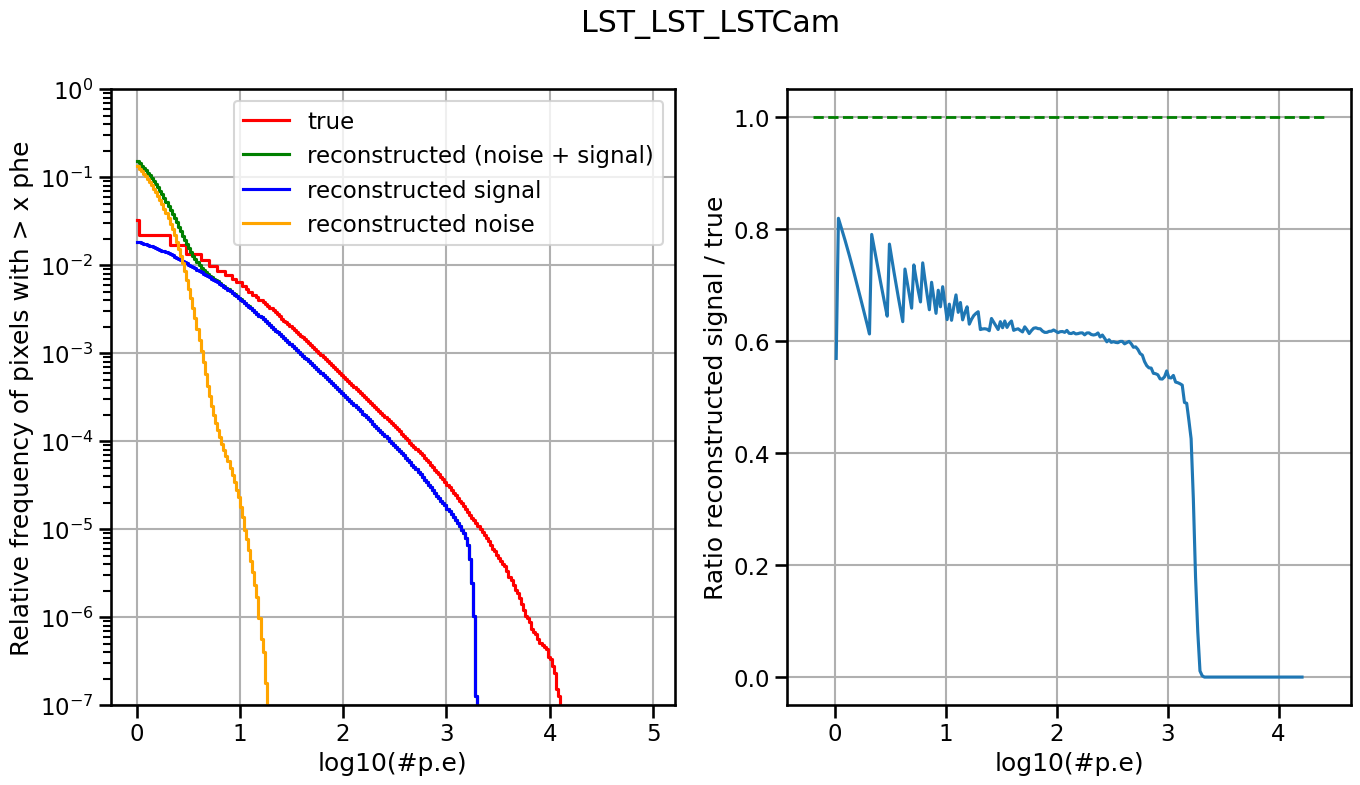

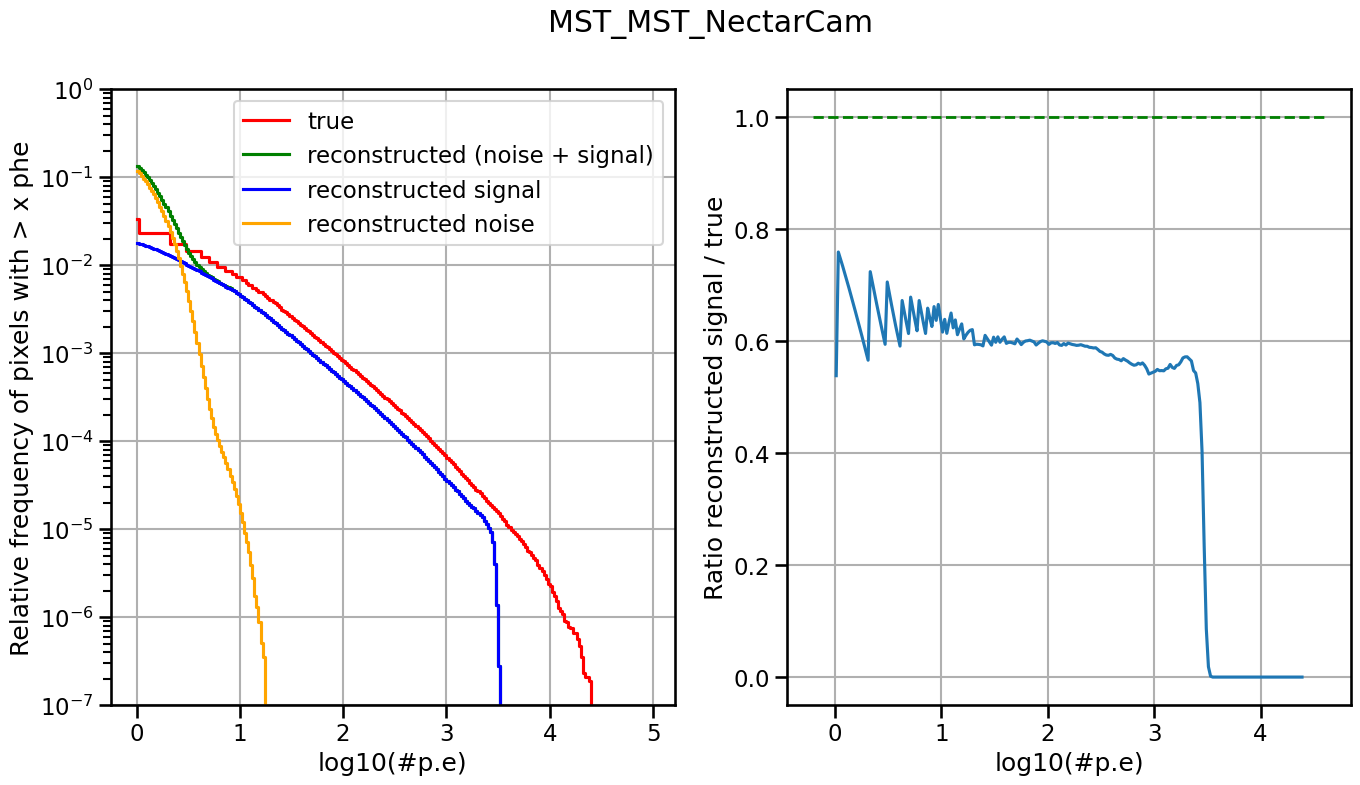

In [36]:
for tel_type in sorted(tel_types):

        fig = plt.figure(figsize=(double_plot_width, double_plot_height), tight_layout=False)
        plt.subplots_adjust(hspace=0.4)

        plt.suptitle(tel_type)

        plt.subplot(1, 2, 1)
        
        true = true_pixel_values[tel_type]
        
        x_bin_edges = np.around(np.arange(0, 5.0, 0.02), 2)
        xrange = [min(x_bin_edges), max(x_bin_edges)]
        
        if is_double_pass:
            reco = reco_pixel_values_2ndPass[tel_type]
        else:
            reco = reco_pixel_values[tel_type]

        signal = reco[true_pixel_values_2ndPass[tel_type] > 0]
        noise = reco[true_pixel_values_2ndPass[tel_type] == 0]

        X_true, Y_true = plot_spectrum(true,
                      x_bin_edges,
                      len(true), # total entries
                      xrange,
                      drawstyle="steps-post",
                      label="true", 
                      color='red')

        X_reco, Y_reco = plot_spectrum(reco,
                      x_bin_edges,
                      len(true), # total entries
                      xrange,
                      drawstyle="steps-post",
                      label="reconstructed (noise + signal)", 
                      color='green')
        
        X_reco_signal, Y_reco_signal = plot_spectrum(signal,
                      x_bin_edges,
                      len(true), # total entries
                      xrange,
                      drawstyle="steps-post",
                      label="reconstructed signal", 
                      color='blue')
        
        X_reco_noise, Y_reco_noise = plot_spectrum(noise,
                      x_bin_edges,
                      len(true), # total entries
                      xrange,
                      drawstyle="steps-post",
                      label="reconstructed noise", 
                      color='orange')
        
        plt.legend()
        plt.grid()
        plt.ylim(1.e-7, 1.e0)
        plt.xlabel("log10(#p.e)")
        plt.ylabel("Relative frequency of pixels with > x phe")

        plt.subplot(1, 2, 2)
        
        plt.xlabel("log10(#p.e)")
        plt.ylabel("Ratio reconstructed signal / true")
        ratio = Y_reco_signal/Y_true
        plt.plot(0.5 * (x_bin_edges[1:] + x_bin_edges[:-1]), ratio)
        ax = plt.gca()
        xlims=ax.get_xlim()
        plt.hlines(1.0, xmin=min(xlims), xmax=max(xlims), ls="dashed", lw=2, color="green")
        plt.grid()

        plt.show()

## Charge resolution and bias for true signal pixels
[back to top](#Table-of-contents)

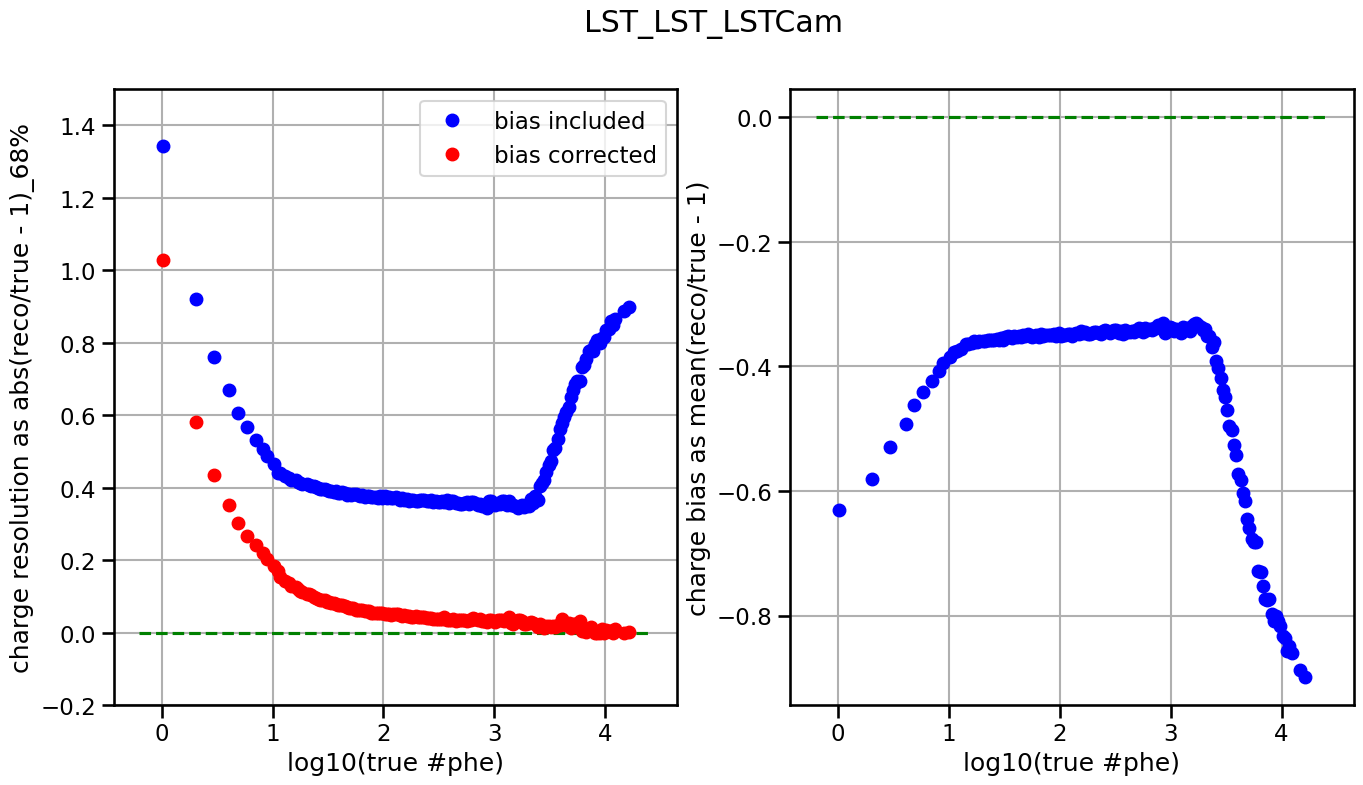

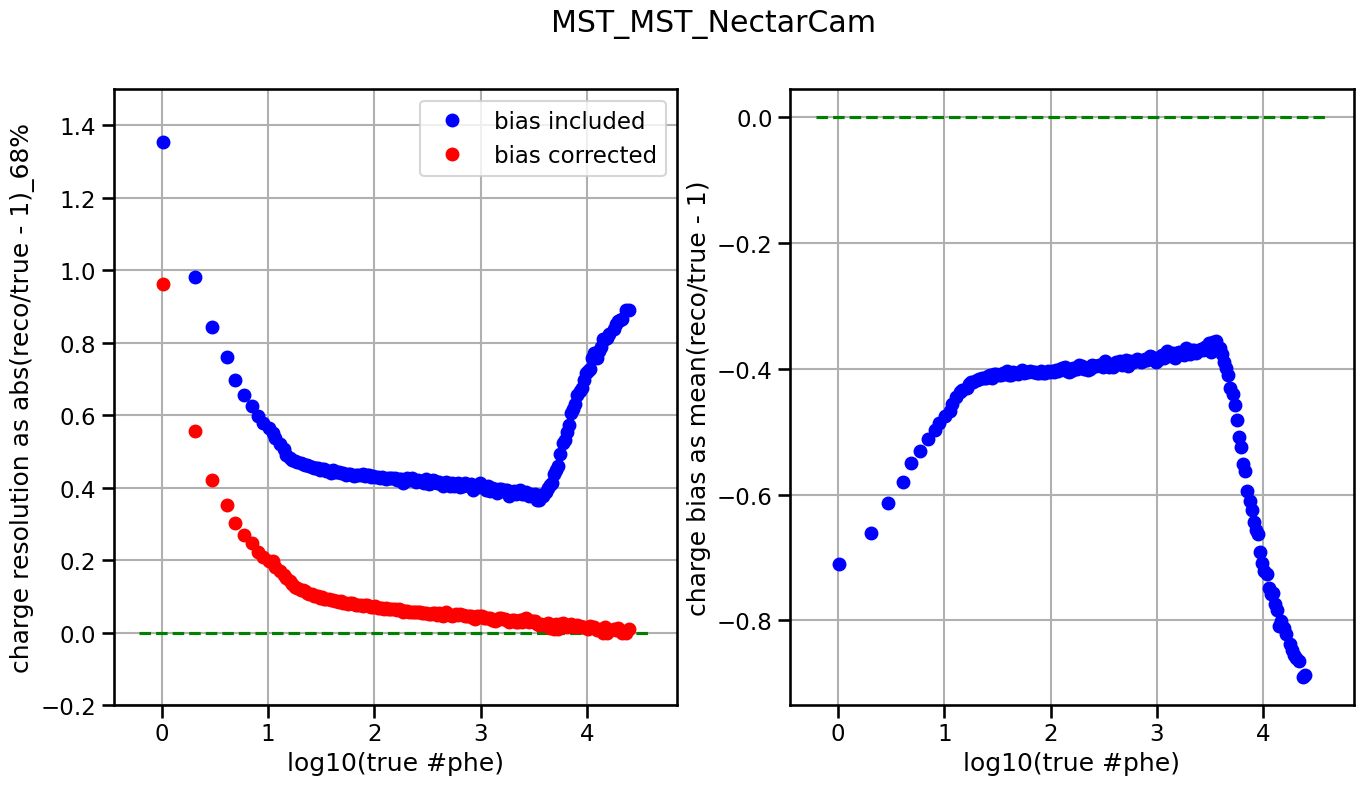

In [37]:
x_bin_edges = np.around(np.arange(0, 5.0, 0.02), 2)
x_bin_centers = 0.5 * (x_bin_edges[1:] + x_bin_edges[:-1])
xrange = [min(x_bin_edges), max(x_bin_edges)]

for tel_type in sorted(tel_types):
        
        fig = plt.figure(figsize=(double_plot_width, double_plot_height), tight_layout=False)
        plt.subplots_adjust(hspace=0.4)

        plt.suptitle(tel_type)
        
        true = true_pixel_values[tel_type]
        signal_mask = true > 0
        
        if is_double_pass:
            true = true_pixel_values_2ndPass[tel_type]
            signal_mask = true > 0
            reco = reco_pixel_values_2ndPass[tel_type][signal_mask]
        else:
            reco = reco_pixel_values[tel_type][signal_mask]
        
        # CHARGE RESOLUTION
        plt.subplot(1, 2, 1)
        
        resolution = binned_statistic(np.log10(true[signal_mask]),
                                      reco/true[signal_mask] - 1,
                                      statistic = lambda x: np.percentile(np.abs(x), 68),
                                      bins=x_bin_edges,)

        corr_resolution = binned_statistic(np.log10(true[signal_mask]),
                                          reco/true[signal_mask] - 1,
                                          statistic = lambda x: np.percentile(np.abs(x-np.mean(x)), 68),
                                          bins=x_bin_edges)
        
        plt.plot(x_bin_centers, resolution[0], "bo", label="bias included")
        plt.plot(x_bin_centers, corr_resolution[0], "ro", label="bias corrected")
        
        plt.hlines(0.0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], ls="--", color="green")

        plt.grid(which="both", axis="both")
        plt.xlabel('log10(true #phe)')
        plt.ylabel('charge resolution as abs(reco/true - 1)_68%')
        plt.legend(loc="best")
        plt.ylim(-0.2, 1.5)
        
        # CHARGE BIAS
        plt.subplot(1, 2, 2)
        
        bias = binned_statistic(np.log10(true[signal_mask]), 
                        reco/true[signal_mask] - 1, 
                        statistic="mean", 
                        bins=x_bin_edges)


        plt.plot(x_bin_centers, bias[0], "bo")
        plt.hlines(0.0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], ls="--", color="green")

        plt.grid(which="both", axis="both")
        plt.xlabel('log10(true #phe)')
        plt.ylabel('charge bias as mean(reco/true - 1)')

        plt.show()

## Noise distribution
[back to top](#Table-of-contents)

If pedestals have been correctly subtracted, we should see that the distributions peak around 0.

If the peak extraction method is ``LocalPeakWindowSum`` or ``TwoPassWindowSum`` _without_ the 2nd pass or similar, please take into account that those are biased methods: they will always catch the highest peak, regardless if due to signal or noise.

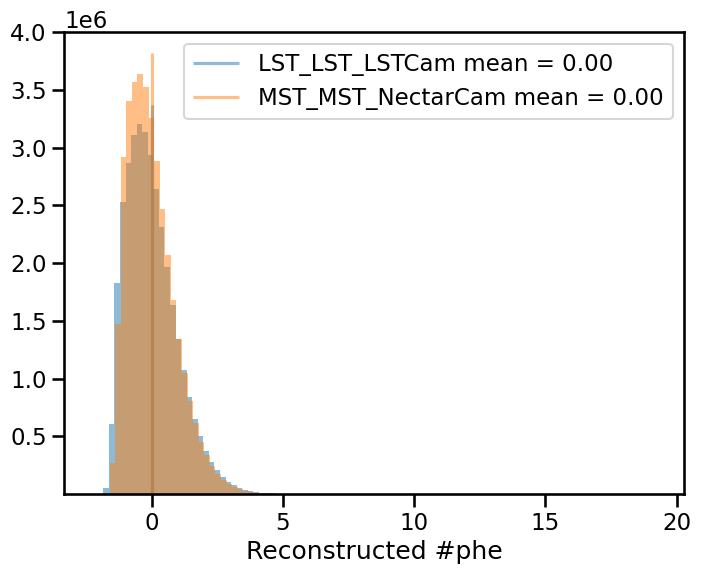

In [38]:
fig = plt.figure(figsize=(single_plot_width, single_plot_height), tight_layout=False)

for tel_type in sorted(tel_types):
        
        true = true_pixel_values[tel_type]
        noise_mask = (true == 0)
        
        if is_double_pass:
            true = true_pixel_values_2ndPass[tel_type]
            noise_mask = (true == 0)
            reco = reco_pixel_values_2ndPass[tel_type]
        else:
            reco = reco_pixel_values[tel_type]
        
        reconstructed_noise_pixels = reco[noise_mask]
        residual_pedestals = reconstructed_noise_pixels.mean()
        
        _, _, patches = plt.hist(reconstructed_noise_pixels, bins=100, alpha=0.5)
        plt.vlines(residual_pedestals,
                   ymin=plt.gca().get_ylim()[0],
                   ymax=plt.gca().get_ylim()[1],
                   color=patches[0].get_facecolor(),
                   label=f"{tel_type} mean = {residual_pedestals:.2f}")

plt.vlines(0,
           ymin=plt.gca().get_ylim()[0],
           ymax=plt.gca().get_ylim()[0])
plt.legend()
plt.ylim(1,4.e6)
plt.xlabel("Reconstructed #phe")

plt.show()

None